In [1]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as aet #pt
from scipy.special import expit as logistic
import arviz as az
from scipy import stats

import statsmodels.api as sm
import scipy.stats as stats

import matplotlib.patheffects as path_effects
from itertools import product
import datetime as dt
from tqdm import tqdm
import seaborn as sns
sns.set_style("whitegrid")

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)-np.log(1-p)

In [2]:
president_polls_url = 'https://projects.fivethirtyeight.com/polls/data/president_polls_historical.csv'
df = pd.read_csv(president_polls_url)
df.to_csv("../Data/raw/president_polls_historical.csv")

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/3546669014.py:2: DtypeWarning: Columns (16,17,26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(president_polls_url)


In [3]:
df = pd.read_csv("../Data/raw/president_polls_historical.csv")

df_state = pd.read_csv("../Data/clean/state_code.csv")

df.loc[df['party'].isin(['REP', 'DEM']) == False, 'party'] = 'OTH'
#df.loc[(df['party'].isin(['REP', 'DEM']) == False) & (df['answer'] != 'Kennedy'), 'party'] = 'OTH'
df = df[df['party'] != 'OTH']

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/3189127009.py:1: DtypeWarning: Columns (17,18,27,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/raw/president_polls_historical.csv")


In [4]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/3015971515.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_date'] = pd.to_datetime(df['start_date'])
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/3015971515.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['end_date'] = pd.to_datetime(df['end_date'])


In [5]:
df['median_date'] = df['start_date'] + (df['end_date'] - df['start_date']) / 2
df.median_date = df.median_date.dt.round('D')

In [6]:
df['date'] = df.median_date
#df['date'] = df.end_date
df = df[df['date'] >= '2020-01-01'] #Only polls during election year
df['week'] = (df['date'] - pd.Timestamp('2020-11-04')).dt.days // 7
df['day'] = (df['date'] - pd.Timestamp('2020-11-04')).dt.days

df = df.merge(df_state[['state','state_code']], how='left')
df.fillna({'state_code':"US"}, inplace=True)
df['state'] = df['state_code']

df = df.set_index('date')
df = df[["poll_id", "question_id", "pollster_id", "pollster", "methodology", "state", 'population', 'sample_size', 'cycle', 'election_date', 'week', 'day', 'party', 'answer',
       'candidate_id', 'candidate_name', 'pct']]

In [7]:
df['year'] = df.index.year
df['month'] = df.index.month

df = df.dropna()

In [8]:
df2 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['answer']) == {'Trump', 'Biden'})

df_count = df2.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df2.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way = df_polls.merge(df_count)
df_2way = df_2way.rename(columns={'REP':'GOP'})
df_2way['type'] = '2way'

#df_2way['sample_size'] = round(df_2way['sample_size'] * (df_2way['DEM'] + df_2way['GOP'])/100)
df_2way[['DEM', 'GOP']] = df_2way[['DEM', 'GOP']].div(100)

In [9]:
df = df_2way
df.dropna()
df['obs_id'] = range(len(df))
df['OTHER'] = 1 - (df['DEM'] + df['GOP'])

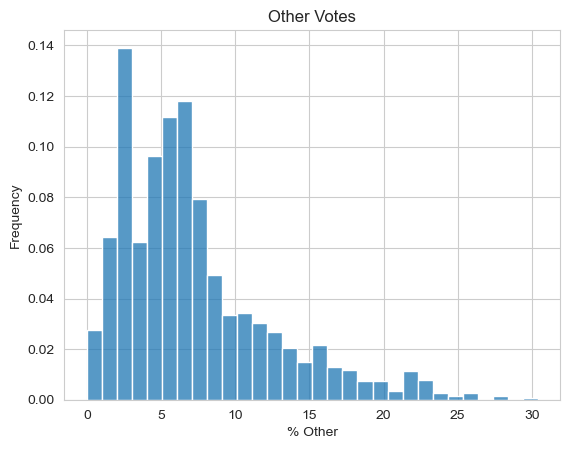

In [10]:
bin_width = 1
max_value = (100 * df.query("state == 'US'")['OTHER']).max()
bins = int(max_value / bin_width)

sns.histplot(100 * df.query("state == 'US'")['OTHER'], bins=bins, stat="probability")
plt.xlabel('% Other')
plt.ylabel('Frequency')
plt.title('Other Votes')

plt.savefig('other_performance.png')

In [11]:
df = df.query("OTHER > 0")

Two way Biden vs Trump, Biden loses by 0.3%. Kamala loses by 4.8%. This is because Kamala's polling occured more after the race moved in Trump's favor.

In [12]:
df_2way[['DEM', 'GOP']].describe()

,DEM,GOP
count,5863.000000,5863.000000
mean,0.502975,0.447729
std,0.078780,0.080680
min,0.214800,0.050000
25%,0.460000,0.410000
50%,0.500000,0.440000
75%,0.530000,0.486000
max,0.940000,0.782800


In [13]:
POLLSTERS = df['pollster'].sort_values().unique()
POLLSTERS_top = df.groupby('pollster').size().sort_values(ascending=False).head(20).index.values

METHODS = df['methodology'].sort_values().unique()
METHODS_top = df.groupby('methodology').size().sort_values(ascending=False).head(10).index.values

STATES = df['state'].sort_values().unique()
STATES_top = df.groupby('state').size().sort_values(ascending=False).head(20).index.values

POPULATIONS = df['population'].sort_values().unique()
POPULATIONS_top = df.groupby('population').size().sort_values(ascending=False).head(10).index.values

There have been polls since Spring 2019, and increased exponentially through election day.

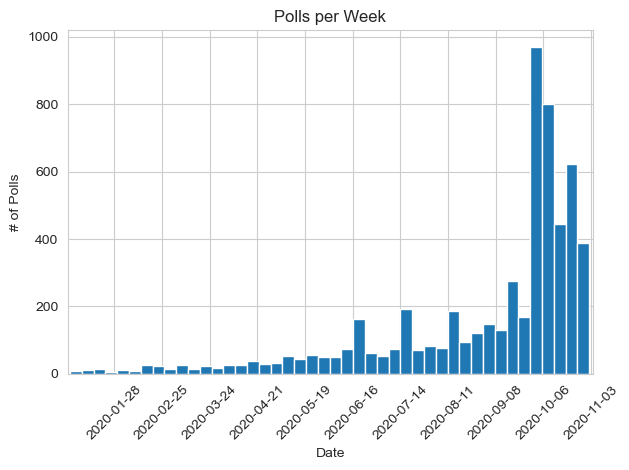

In [14]:
# Create the plot
fig, ax = plt.subplots()

# Plot histogram of the dates
df['date'].hist(bins=len(df['week'].unique()), ax=ax)

# Set the x-axis limit to the desired date range
ax.set_xlim([dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 4)])

# Format the x-axis as dates
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.WeekdayLocator(interval=4))  # Adjust the tick interval as needed

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('# of Polls')
plt.title('Polls per Week')

# Save the plot
plt.tight_layout()
plt.savefig('weekly_polls.png')
plt.show()


In [15]:
# Create the cross-tabulation
cross_tab = pd.crosstab(df['pollster'], df['methodology'], margins=True)

# Extract 'All' row and 'All' column
all_row = cross_tab.loc['All']
all_col = cross_tab['All']

# Sort rows by 'All' column values (excluding the 'All' row)
sorted_rows = all_col.index[all_col.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_rows)

# Sort columns by 'All' row values (excluding the 'All' column)
sorted_columns = all_row.index[all_row.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_columns, axis=1)

cross_tab.iloc[:11, :11]

methodology,All,Online Panel,Live Phone,Probability Panel,IVR/Text,Live Phone/Online Panel,Text-to-Web/Online Ad,IVR/Online Panel,Online Ad,Online Panel/Text-to-Web,IVR/Live Phone/Text/Online Panel/Email
pollster,,,,,,,,,,,
All,5802,3954,622,400,110,101,100,93,57,50,46
SurveyMonkey,2840,2840,0,0,0,0,0,0,0,0,0
Morning Consult,461,461,0,0,0,0,0,0,0,0,0
USC Dornsife,214,0,0,214,0,0,0,0,0,0,0
Ipsos,176,1,0,175,0,0,0,0,0,0,0
YouGov,146,146,0,0,0,0,0,0,0,0,0
Change Research,104,2,0,0,0,0,100,0,2,0,0
Data for Progress,96,45,0,0,0,0,0,0,0,50,0
Redfield & Wilton Strategies,94,88,6,0,0,0,0,0,0,0,0


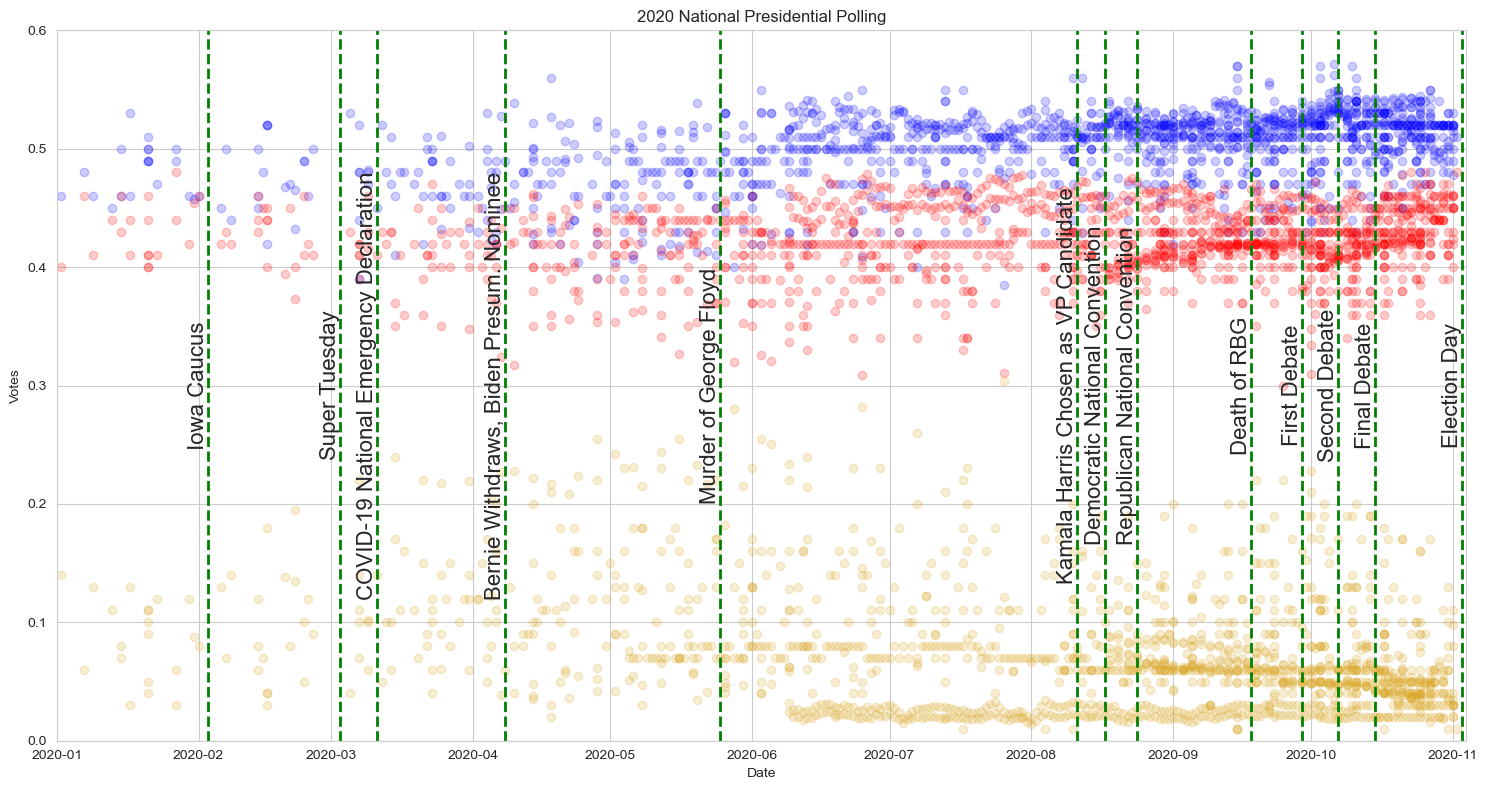

In [16]:
dem_votes = df.query("state == 'US'")["DEM"].values
gop_votes = df.query("state == 'US'")["GOP"].values
oth_votes = df.query("state == 'US'")["OTHER"].values

dates = df.query("state == 'US'").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, dem_votes, "o", alpha=0.2, color='blue', label="Biden")
ax.plot(dates, gop_votes, "o", alpha=0.2, color='red', label="Trump")
ax.plot(dates, oth_votes, "o", alpha=0.2, color='goldenrod', label="Other")

# Set limits and labels
ax.set_ylim(0, 0.6)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 4))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2020 National Presidential Polling')

events = [
            (dt.datetime(2020, 3, 11), 'COVID-19 National Emergency Declaration'),
            (dt.datetime(2020, 2, 3), 'Iowa Caucus'),
            (dt.datetime(2020, 3, 3), 'Super Tuesday'),
            (dt.datetime(2020, 4, 8), 'Bernie Withdraws, Biden Presum. Nominee'),
            (dt.datetime(2020, 5, 25), 'Murder of George Floyd'),
            (dt.datetime(2020, 8, 11), 'Kamala Harris Chosen as VP Candidate'),
            (dt.datetime(2020, 8, 17), 'Democratic National Convention'),
            (dt.datetime(2020, 8, 24), 'Republican National Convention'),
            (dt.datetime(2020, 9, 18), 'Death of RBG'),
            (dt.datetime(2020, 9, 29), 'First Debate'),
            (dt.datetime(2020, 10, 7), 'Second Debate'),
            (dt.datetime(2020, 10, 15), 'Final Debate'),
            (dt.datetime(2020, 11, 3), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.3, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, '30-Day Rolling National Polling Standard Deviation')

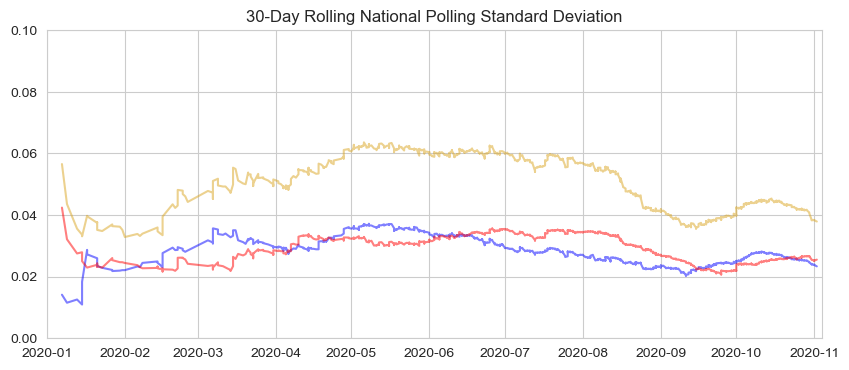

In [17]:
rolling_mean = (
    df.query("state == 'US'")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='30D')
    .std()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=0.5,
)


ax.set_ylim(0, .1)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 4))
ax.set_title("30-Day Rolling National Polling Standard Deviation")

Text(0.5, 1.0, '7-Day Rolling National Polling Mean')

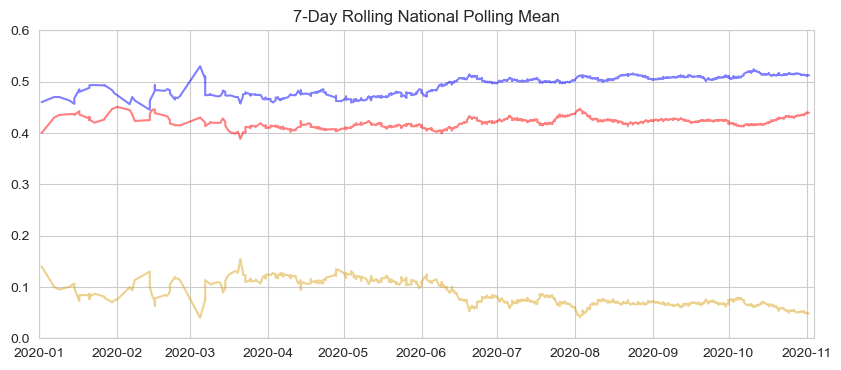

In [18]:
rolling_mean = (
    df.query("state == 'US'")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='7D')
    .mean()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=0.5,
)


ax.set_ylim(0, .6)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 4))
ax.set_title("7-Day Rolling National Polling Mean")

Text(0.5, 1.0, '7-Day Rolling National Polling Standard Deviation')

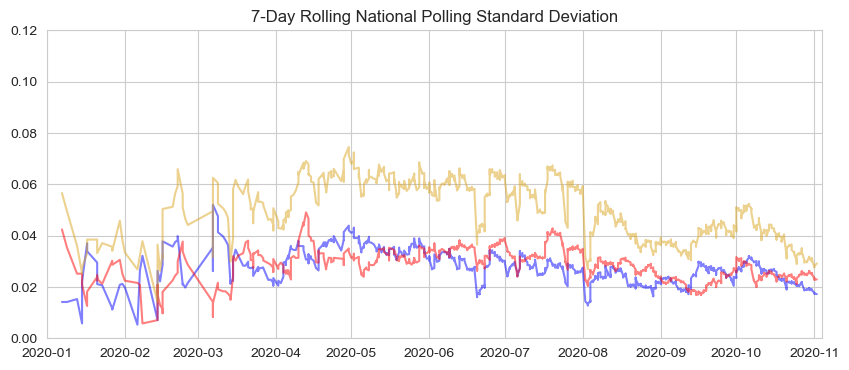

In [19]:
rolling_mean = (
    df.query("state == 'US'")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='7D')
    .std()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=0.5,
)


ax.set_ylim(0, .12)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 4))
ax.set_title("7-Day Rolling National Polling Standard Deviation")

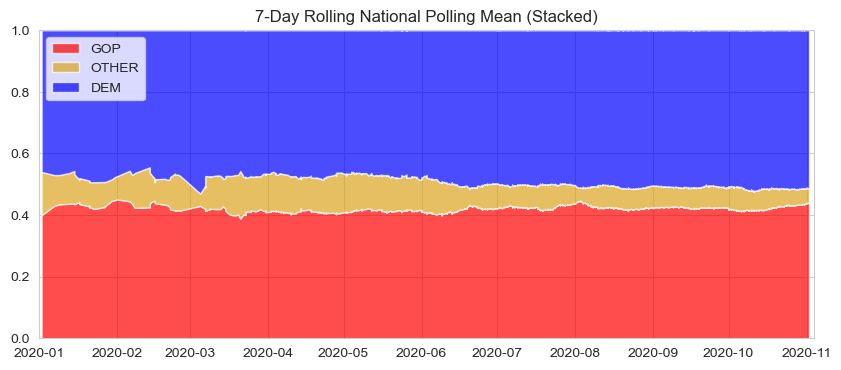

In [20]:
rolling_mean = (
    df.query("state == 'US'")[["date", "GOP", "OTHER", "DEM"]]
    .set_index("date")
    .sort_index()  # Ensure the index is sorted
    .rolling(window='7D')
    .mean()
    .reset_index()[["date", "GOP", "OTHER", "DEM"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))

ax.stackplot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    rolling_mean.OTHER.values,
    rolling_mean.DEM.values,
    labels=["GOP", "OTHER", "DEM"],
    colors=['red', 'goldenrod', 'blue'],
    alpha=0.7,
)

ax.set_ylim(0, 1)  # Adjusted to fit the stacked plot
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 4))
ax.set_title("7-Day Rolling National Polling Mean (Stacked)")
ax.legend(loc='upper left')

plt.show()

We can see here that polling methodology is irrelevant, they all perform about the same.

In [21]:
df.query("state == 'US'").query("methodology in ['Online Panel','Live Phone','Probability Panel','Online Ad']")[['methodology','DEM','GOP','OTHER']].groupby("methodology").mean()

,DEM,GOP,OTHER
methodology,,,
Live Phone,0.507624,0.419650,0.072726
Online Ad,0.498729,0.415293,0.085979
Online Panel,0.502277,0.428308,0.069415
Probability Panel,0.503910,0.404901,0.091189


We can see that Trump fairly consistently under-performs on Probability Panel polls.

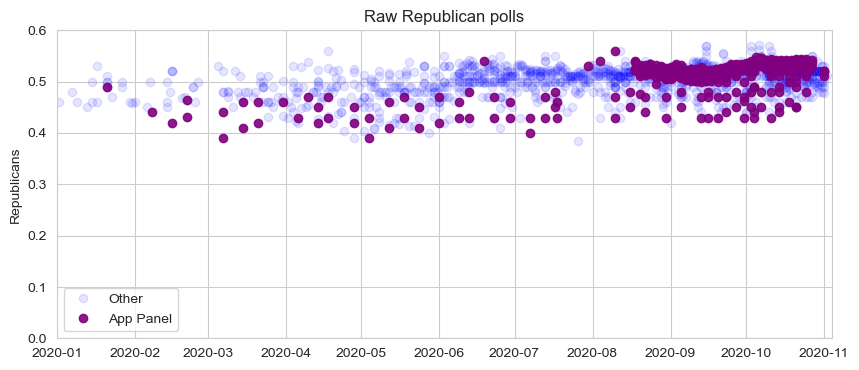

In [22]:
face = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == "Probability Panel"]
face = face.set_index("date")
dates_face = face.index

other = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] != "Probability Panel"]
other = other.set_index("date")
dates_other = other.index

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dates_other, other["DEM"].values, "o", alpha=0.1, color = 'blue', label="Other")
ax.plot(dates_face, face["DEM"].values, "o", alpha=.9, color = 'purple', label="App Panel")
ax.set_ylim(0, .6)
ax.set_ylabel("Republicans")
ax.set_title("Raw Republican polls")

ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 4))
ax.legend()

In [23]:
df["margin"] = df.apply(lambda row: (row['DEM'] - row['GOP']), axis=1)

df = (
    df.reset_index()
    .merge(
        df.groupby(["week","type"])[["GOP", "DEM", "margin"]].mean().reset_index(),
        on=["week","type"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/2205799714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["margin"] = df.apply(lambda row: (row['DEM'] - row['GOP']), axis=1)


In [24]:
df["diff_GOP"] = df["GOP"] - df["GOP_mean"]
df["diff_DEM"] = df["DEM"] - df["DEM_mean"]

df["diff_margin"] = df["margin"] - df["margin_mean"]

In [25]:
x_res = np.maximum(df.query("state == 'US'").margin.quantile(q=1), df.query("state == 'US'").margin.quantile(q=0) * -1)

In [26]:
df.pollster.value_counts().head(30)

pollster
SurveyMonkey                           2840
Morning Consult                         461
USC Dornsife                            214
Ipsos                                   176
YouGov                                  146
Change Research                         104
Data for Progress                        96
Redfield & Wilton Strategies             94
PPP                                      79
TIPP                                     64
Monmouth                                 63
Øptimus                                  52
Quinnipiac                               50
Beacon/Shaw                              50
Civiqs                                   47
RMG Research                             47
Trafalgar Group                          46
Siena/NYT                                46
Swayable                                 45
ABC/Washington Post                      45
Rasmussen                                39
Marist                                   33
CNN/SSRS               

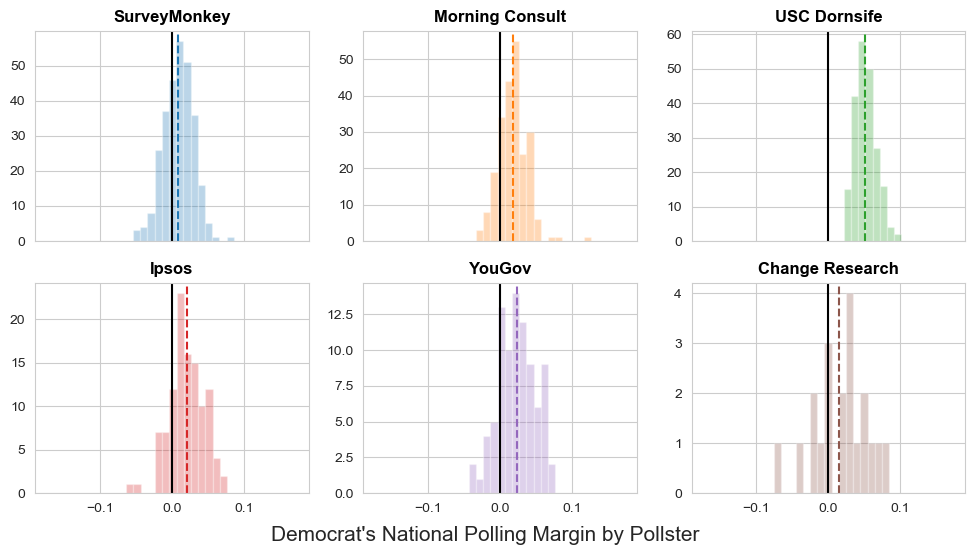

In [27]:
POLLSTER_VALS = {
    pollster: df.query("state == 'US'")[df.query("state == 'US'")["pollster"] == pollster]["diff_margin"].values
    for pollster in list(POLLSTERS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=3, nrows=2, sharex=True, figsize=(12, 6))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    bin_width = 0.01
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-x_res, x_res)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 1.1, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.03, r"Democrat's National Polling Margin by Pollster", ha='center', fontsize=15)

plt.savefig('pollster_margin.png')
plt.show()

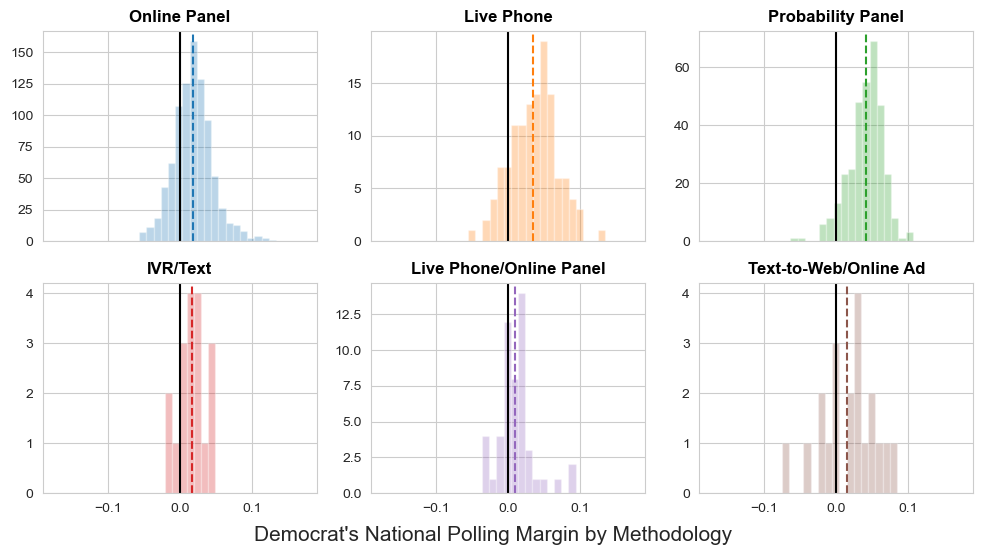

In [28]:
METHOD_VALS = {
    method: df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == method]["diff_margin"].values
    for method in list(METHODS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=3, nrows=2, sharex=True, figsize=(12, 6))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), METHOD_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    bin_width = 0.01
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-x_res, x_res)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 1.1, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.03, r"Democrat's National Polling Margin by Methodology", ha='center', fontsize=15)

plt.savefig('methodology_margin.png')
plt.show()

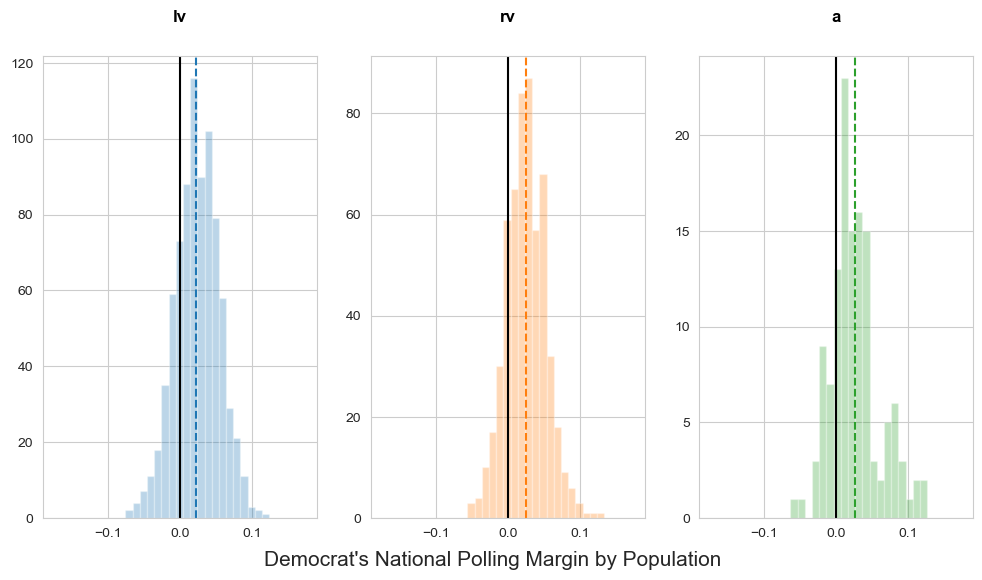

In [29]:
POPULATIONS_VALS = {
    population: df.query("state == 'US'")[df.query("state == 'US'")["population"] == population]["diff_margin"].values
    for population in list(POPULATIONS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, figsize=(12, 6))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POPULATIONS_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    bin_width = 0.01
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-x_res, x_res)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 1.1, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.03, r"Democrat's National Polling Margin by Population", ha='center', fontsize=15)

plt.savefig('population_margin.png')
plt.show()

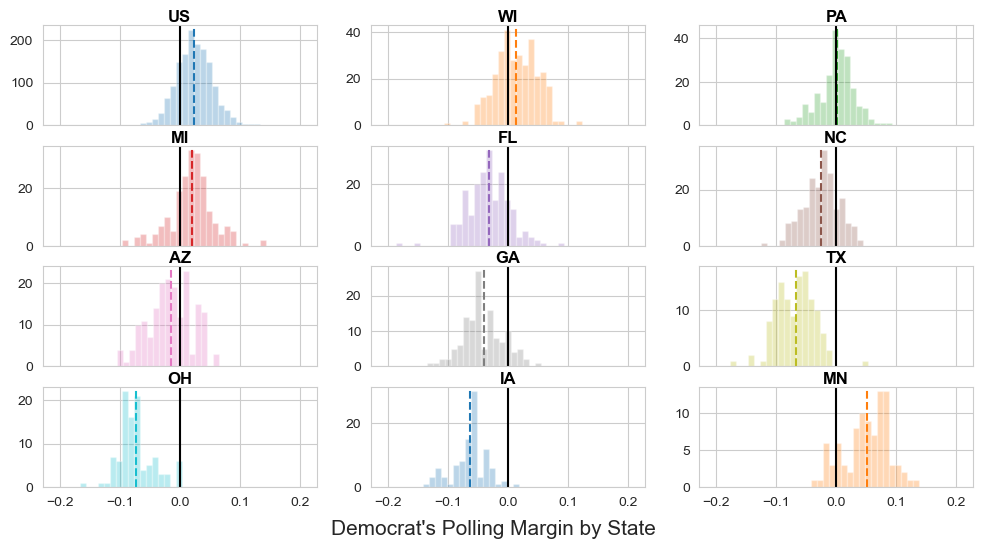

In [30]:
STATE_VALS = {
    state: df[df["state"] == state]["diff_margin"].values
    for state in list(STATES_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(12, 6))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), STATE_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    bin_width = 0.01
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-x_res*1.2, x_res*1.2)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 1.15, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.03, r"Democrat's Polling Margin by State", ha='center', fontsize=15)

plt.savefig('state_margin.png')
plt.show()

In [31]:
date_counts = df['date'].value_counts().reset_index()

# Rename the columns
date_counts.columns = ['date', 'count']

# Sort the DataFrame by date in descending order
date_counts = date_counts.sort_values(by='date', ascending=False).reset_index(drop=True)

In [32]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

#day_id, day = df.set_index(["day"]).index.factorize(sort=True)
day_id = df.day.to_numpy()
day = np.arange(df.day.min(), 1)

party_id, party = [0,1,2], ['DEM','GOP','Other']

pollster_id, pollster = df.set_index(
    ["pollster"]
).index.factorize(sort=True)

method_id, method = df.set_index(
    ["methodology"]
).index.factorize(sort=True)

state_id, state = df.set_index(
    ["state"]
).index.factorize(sort=True)

population_id, population = df.set_index(
    ["population"]
).index.factorize(sort=True)

COORDS = {
    "pollster": pollster,
    "method": method,
    "state": state,
    "party": party,
    "population": population,
    "week": week,
    "day": day,
    "observation": df.obs_id
}

In [33]:
with pm.Model(coords=COORDS) as twoway:

    epsilon = 1e-6  # A small positive number for penalizing deviations

    dem_sigma       = pm.HalfNormal("dem_sigma", sigma=0.1) + epsilon
    dem_rho         = pm.Normal("dem_rho", mu=0, sigma=0.7)
    dem_ar          = pm.AR("dem_ar",
                            rho=[dem_rho] * 7,
                            sigma=dem_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    dem_sigma_rw    = pm.HalfNormal("dem_sigma_rw", sigma=0.1) + epsilon
    dem_random_walk = pm.GaussianRandomWalk("dem_random_walk",
                                            sigma=dem_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    dem_day_effect  = pm.Deterministic("dem_day_effect", dem_ar + dem_random_walk, dims="day")

    dem_pollster_effect = pm.Normal("dem_pollster_effect", 0, 0.2, dims="pollster")
    dem_method_effect   = pm.Normal("dem_method_effect", 0, 0.2, dims="method")
    dem_state_effect    = pm.Normal("dem_state_effect", 0, 0.2, dims="state")
    dem_state_multi     = pm.Normal("dem_state_multi", 1, 0.2, dims="state")
    dem_pop_effect      = pm.Normal("dem_pop_effect", 0, 0.2, dims="population")

    dem_polling = pm.Deterministic("dem_polling", pm.math.invlogit(
        dem_pollster_effect[pollster_id] +
        dem_method_effect[method_id] +
        dem_pop_effect[population_id] +
        dem_state_effect[state_id] +
        dem_state_multi[state_id] *
        dem_day_effect[day_id]
    ),
        dims = "observation")
    
    gop_sigma       = pm.HalfNormal("gop_sigma", sigma=0.1) + epsilon
    gop_rho         = pm.Normal("gop_rho", mu=0, sigma=0.7)
    gop_ar          = pm.AR("gop_ar",
                            rho=[gop_rho] * 7,
                            sigma=gop_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    gop_sigma_rw    = pm.HalfNormal("gop_sigma_rw", sigma=0.1) + epsilon
    gop_random_walk = pm.GaussianRandomWalk("gop_random_walk",
                                            sigma=gop_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    gop_day_effect  = pm.Deterministic("gop_day_effect", gop_ar + gop_random_walk, dims="day")

    gop_pollster_effect = pm.Normal("gop_pollster_effect", 0, 0.2, dims="pollster")
    gop_method_effect   = pm.Normal("gop_method_effect", 0, 0.2, dims="method")
    gop_state_effect    = pm.Normal("gop_state_effect", 0, 0.2, dims="state")
    gop_state_multi     = pm.Normal("gop_state_multi", 1, 0.2, dims="state")
    gop_pop_effect      = pm.Normal("gop_pop_effect", 0, 0.2, dims="population")

    gop_polling = pm.Deterministic("gop_polling", pm.math.invlogit(
        gop_pollster_effect[pollster_id] +
        gop_method_effect[method_id] +
        gop_pop_effect[population_id] +
        gop_state_effect[state_id] +
        gop_state_multi[state_id] *
        gop_day_effect[day_id]
    ),
        dims = "observation")

    oth_sigma       = pm.HalfNormal("oth_sigma", sigma=0.1) + epsilon
    oth_rho         = pm.Normal("oth_rho", mu=0, sigma=0.7)
    oth_ar          = pm.AR("oth_ar",
                            rho=[oth_rho] * 7,
                            sigma=oth_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    oth_sigma_rw    = pm.HalfNormal("oth_sigma_rw", sigma=0.1) + epsilon
    oth_random_walk = pm.GaussianRandomWalk("oth_random_walk",
                                            sigma=oth_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    oth_day_effect  = pm.Deterministic("oth_day_effect", oth_ar + oth_random_walk, dims="day")

    oth_pollster_effect = pm.Normal("oth_pollster_effect", 0, 0.2, dims="pollster")
    oth_method_effect   = pm.Normal("oth_method_effect", 0, 0.2, dims="method")
    oth_state_effect    = pm.Normal("oth_state_effect", 0, 0.2, dims="state")
    oth_state_multi     = pm.Normal("oth_state_multi", 1, 0.2, dims="state")
    oth_pop_effect      = pm.Normal("oth_pop_effect", 0, 0.2, dims="population")

    oth_polling = pm.Deterministic("oth_polling", pm.math.invlogit(
        oth_pollster_effect[pollster_id] +
        oth_method_effect[method_id] +
        oth_pop_effect[population_id] +
        oth_state_effect[state_id] +
        oth_state_multi[state_id] *
        oth_day_effect[day_id]
    ),
        dims = "observation")

    # Binomial likelihoods
    dem_vote = pm.Binomial(
        "dem_vote",
        p = dem_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['DEM'],
        dims = "observation",
    )

    gop_vote = pm.Binomial(
        "gop_vote",
        p = gop_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['GOP'],
        dims = "observation",
    )

    oth_vote = pm.Binomial(
        "oth_vote",
        p = oth_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['OTHER'],
        dims = "observation",
    )

    polling_error_fund_dem = pm.Normal("polling_error_fund_dem", 0, 1)
    polling_error_fund_gop = pm.Deterministic("polling_error_fund_gop", -polling_error_fund_dem)
    polling_error_fund_oth = pm.Deterministic("polling_error_fund_oth", polling_error_fund_dem*0)

    polling_error_state_dem = pm.Normal("polling_error_state_dem", 0, 1, dims="state")
    polling_error_state_gop = pm.Deterministic("polling_error_state_gop", -polling_error_state_dem, dims="state")
    polling_error_state_oth = pm.Deterministic("polling_error_state_oth", polling_error_state_dem*0, dims="state")

    # Sampling
    idata = pm.sample(draws=100, cores=10, return_inferencedata=True, step=pm.NUTS(target_accept=0.95), init='advi+adapt_diag')

Multiprocess sampling (10 chains in 10 jobs)
NUTS: [dem_sigma, dem_rho, dem_ar, dem_sigma_rw, dem_random_walk, dem_pollster_effect, dem_method_effect, dem_state_effect, dem_state_multi, dem_pop_effect, gop_sigma, gop_rho, gop_ar, gop_sigma_rw, gop_random_walk, gop_pollster_effect, gop_method_effect, gop_state_effect, gop_state_multi, gop_pop_effect, oth_sigma, oth_rho, oth_ar, oth_sigma_rw, oth_random_walk, oth_pollster_effect, oth_method_effect, oth_state_effect, oth_state_multi, oth_pop_effect, polling_error_fund_dem, polling_error_state_dem]


Output()

Sampling 10 chains for 1_000 tune and 100 draw iterations (10_000 + 1_000 draws total) took 4613 seconds.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 5 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 6 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 7 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


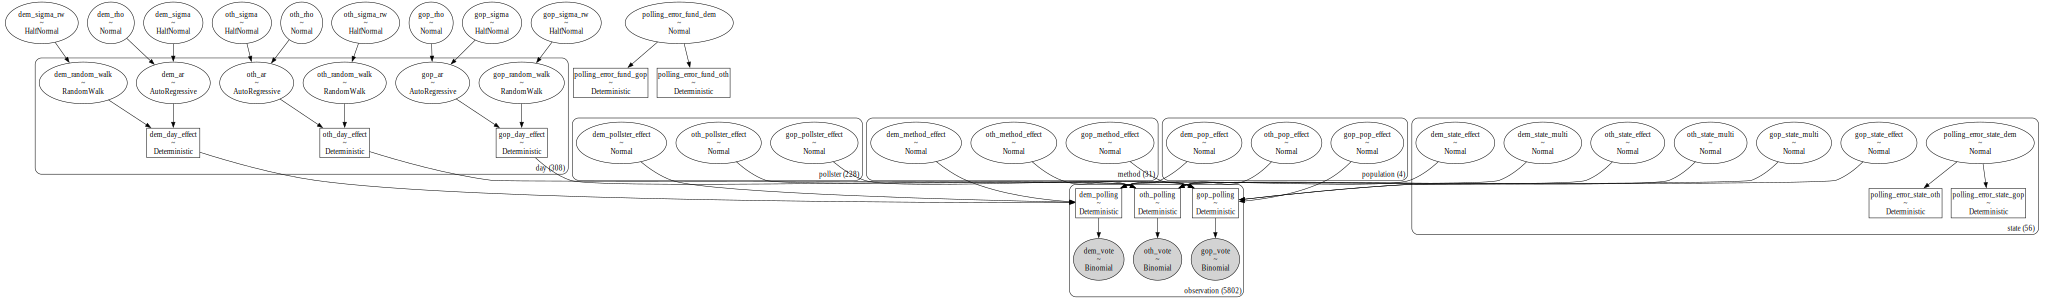

In [34]:
pm.model_to_graphviz(twoway)

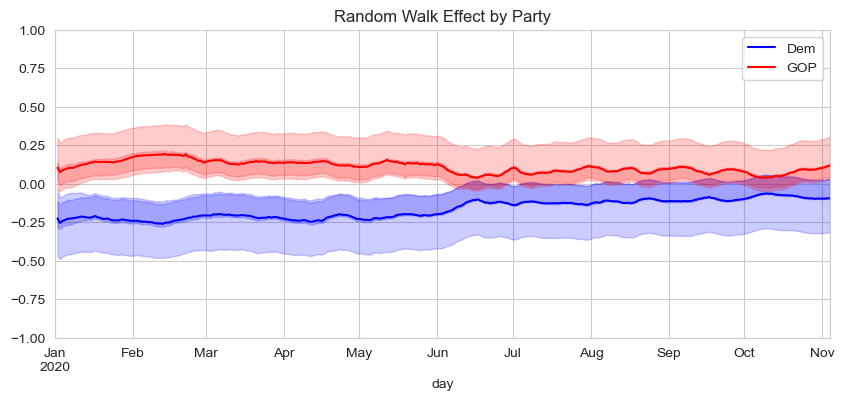

In [35]:
rw = pd.DataFrame()
rw['day'] = pd.date_range(start=df.date.min(), end='2020-11-04')

for party in ['dem', 'gop', 'oth']:
    rw[f"{party}_50"] = idata.posterior[f"{party}_day_effect"].median(dim=["chain", "draw"]).values * idata.posterior[f"{party}_state_multi"].mean(axis=0).mean(axis=0).mean(axis=0).values
    rw[[f"{party}_03",f"{party}_97"]] = az.hdi(idata.posterior[f"{party}_day_effect"], hdi_prob=0.94)[f"{party}_day_effect"]* idata.posterior[f"{party}_state_multi"].mean(axis=0).mean(axis=0).mean(axis=0).values
    rw[[f"{party}_25",f"{party}_75"]] = az.hdi(idata.posterior[f"{party}_day_effect"], hdi_prob=0.50)[f"{party}_day_effect"]* idata.posterior[f"{party}_state_multi"].mean(axis=0).mean(axis=0).mean(axis=0).values

rw = rw.set_index('day')

rolling_mean = (
    rw
    .rolling(window='7D')
    .mean()
)

fig, ax = plt.subplots(figsize=(10, 4))

for party, color, abb in [('dem', 'blue', 'Dem'), ('gop', 'red', 'GOP')]:
    
    rolling_mean[f"{party}_50"].plot(color=f"{color}", label=f'{abb}')
    plt.fill_between(rw.index, rolling_mean[f"{party}_03"].ffill(), rolling_mean[f"{party}_97"].ffill(), color=f"{color}", alpha=0.2)
    plt.fill_between(rw.index, rolling_mean[f"{party}_25"].ffill(), rolling_mean[f"{party}_75"].ffill(), color=f"{color}", alpha=0.2)

ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 4))
ax.set_ylim(-1,1)
ax.set_title("Random Walk Effect by Party")
ax.legend()

plt.show()

In [36]:
states = df['state'].unique()
parties = ['dem','gop','margin','oth']

combinations = [f"{state}_{party}" for state, party in product(states, parties)]

In [547]:
interim = pd.DataFrame()

for party in ['dem', 'gop', 'oth']:
    pollster_effects = (
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="YouGov") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Monmouth") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Siena/NYT") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="ABC/Washington Post") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Ipsos")
    ).values / 5
    pollster_effects_flat = pollster_effects.ravel()
    interim[f"pollster_effects_{party}"] = pollster_effects_flat

    method_effects = (
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone', drop=True).mean(axis=2) +
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Probability Panel', drop=True).mean(axis=2)
    )/2
    method_effects_flat = pollster_effects.ravel()
    interim[f"method_effects_{party}"] = pollster_effects_flat

    pop_effects = (
        idata.posterior[f"{party}_pop_effect"].sel(population="lv")
    ).values
    pop_effects_flat = pop_effects.ravel()
    interim[f"pop_effects_{party}"] = pop_effects_flat

    interim[f"polling_error_{party}"] = idata.posterior[f"polling_error_fund_{party}"].values.ravel()

    interim[f"fund_{party}"] = interim[f"pollster_effects_{party}"] + interim[f"method_effects_{party}"] + interim[f"pop_effects_{party}"] #+ 0.0625 * interim[f"polling_error_{party}"]

<Axes: >

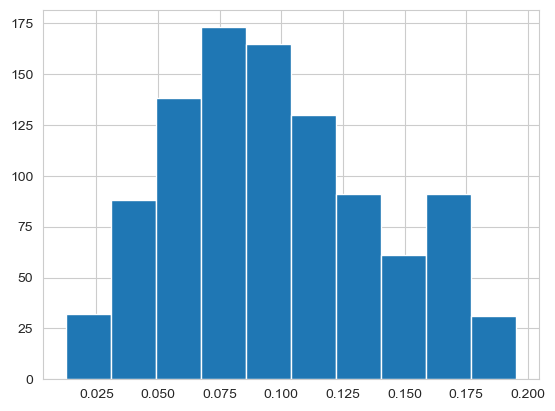

In [458]:
(inv_logit(
    interim["fund_dem"]
    )
-
 inv_logit(
     interim["fund_gop"]
 )
).hist()

In [459]:
(inv_logit(
    interim["fund_dem"]
    )
-
 inv_logit(
     interim["fund_gop"]
 )
).std()

0.04165760607982399

<Axes: >

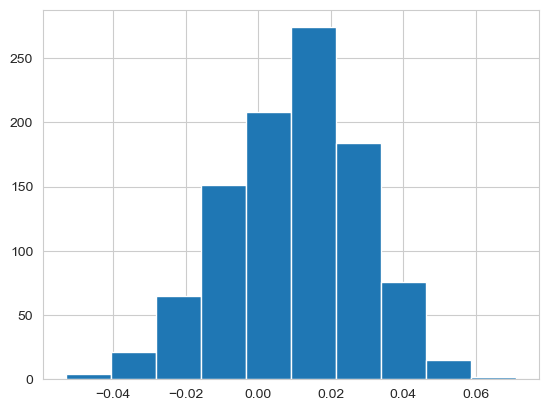

In [460]:
(inv_logit(
            interim["fund_dem"] +
            idata.posterior["dem_state_effect"].sel(state="GA").values.ravel() +
            idata.posterior["dem_state_multi"].sel(state="GA").values.ravel() *
            idata.posterior["dem_day_effect"].sel(day=0).values.ravel()
            )
-inv_logit(
            interim["fund_gop"] +
            idata.posterior["gop_state_effect"].sel(state="GA").values.ravel() +
            idata.posterior["gop_state_multi"].sel(state="GA").values.ravel() *
            idata.posterior["gop_day_effect"].sel(day=0).values.ravel()
            )
).hist()

In [461]:
(inv_logit(
            interim["fund_dem"] +
            idata.posterior["dem_state_effect"].sel(state="GA").values.ravel() +
            idata.posterior["dem_state_multi"].sel(state="GA").values.ravel() *
            idata.posterior["dem_day_effect"].sel(day=0).values.ravel()
            )
-inv_logit(
            interim["fund_gop"] +
            idata.posterior["gop_state_effect"].sel(state="GA").values.ravel() +
            idata.posterior["gop_state_multi"].sel(state="GA").values.ravel() *
            idata.posterior["gop_day_effect"].sel(day=0).values.ravel()
            )
).std()

0.018577549089867102

<Axes: >

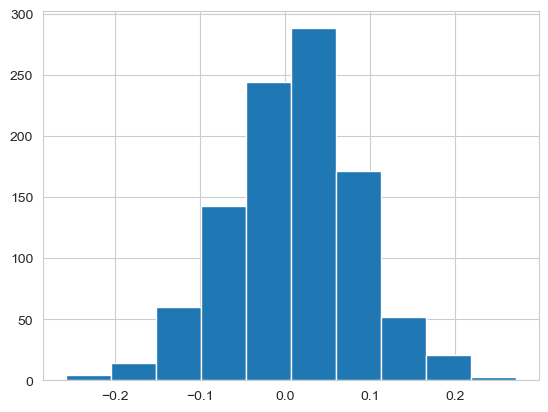

In [462]:
(inv_logit(
            interim["fund_dem"] +
            idata.posterior["dem_state_effect"].sel(state="GA").values.ravel() +
            0.15 * idata.posterior["polling_error_state_dem"].sel(state="GA").values.ravel() +
            idata.posterior["dem_state_multi"].sel(state="GA").values.ravel() *
            idata.posterior["dem_day_effect"].sel(day=0).values.ravel()
            )
-inv_logit(
            interim["fund_gop"] +
            idata.posterior["gop_state_effect"].sel(state="GA").values.ravel() +
            0.15 * idata.posterior["polling_error_state_gop"].sel(state="GA").values.ravel() +
            idata.posterior["gop_state_multi"].sel(state="GA").values.ravel() *
            idata.posterior["gop_day_effect"].sel(day=0).values.ravel()
            )
).hist()

In [603]:
(inv_logit(
            idata.posterior["dem_state_effect"].sel(state="GA").values.ravel() +
            0.067 * idata.posterior["polling_error_state_dem"].sel(state="GA").values.ravel() #+
            #idata.posterior["dem_state_multi"].sel(state="GA").values.ravel() *
            #idata.posterior["dem_day_effect"].sel(day=0).values.ravel()
            )
-inv_logit(
            idata.posterior["gop_state_effect"].sel(state="GA").values.ravel() +
            0.067 * idata.posterior["polling_error_state_gop"].sel(state="GA").values.ravel() #+
            #idata.posterior["gop_state_multi"].sel(state="GA").values.ravel() *
            #idata.posterior["gop_day_effect"].sel(day=0).values.ravel()
            )
).std()

0.034535337893517974

In [403]:
inv_logit(interim.fund_dem+0.125*interim.polling_error_dem).std()

0.054115515394652265

In [404]:
(inv_logit(.1)-.5)*100

2.4979187478940013

In [646]:
df_results = pd.DataFrame(columns=combinations)
df_day_mean = pd.DataFrame(index=day, columns=combinations)
df_day_03 =  pd.DataFrame(index=day, columns=combinations)
df_day_25 =  pd.DataFrame(index=day, columns=combinations)
df_day_75 =  pd.DataFrame(index=day, columns=combinations)
df_day_97 =  pd.DataFrame(index=day, columns=combinations)

#for d in [-18]:
for d in tqdm(day):
    day_results = {}
    for state in states:
        for party in ['dem', 'gop', 'oth']:
            polling_error = 0 if state == 'US' else 0.067 * idata.posterior[f"polling_error_state_{party}"].sel(state=f"{state}").values.ravel()
            day_results[f"{state}_{party}"] = inv_logit(
                interim[f"fund_{party}"] +
                idata.posterior[f"{party}_state_effect"].sel(state=f"{state}").values.ravel() +
                polling_error +
                idata.posterior[f"{party}_state_multi"].sel(state=f"{state}").values.ravel() *
                (idata.posterior[f"{party}_day_effect"].sel(day=d).values.ravel()
                #+ (.1 if party == 'gop' else 0) # 2% swing towards GOP
                #+ (.05 if party == 'dem' else 0) # 1% swing towards DEM
                )  
            ).to_numpy()

        # Calculate total votes and normalize
        total = sum(day_results[f"{state}_{party}"] for party in ['dem', 'gop', 'oth'])
        for party in ['dem', 'gop', 'oth']:
            day_results[f"{state}_{party}"] /= total
        
        # Calculate margin
        day_results[f"{state}_margin"] = day_results[f"{state}_dem"] - day_results[f"{state}_gop"]

    # Convert day_results to DataFrame
    df_results = pd.DataFrame(day_results)

    # Store quantiles and mean for this day
    df_day_03.loc[d] = df_results.quantile(0.03)
    df_day_25.loc[d] = df_results.quantile(0.25)
    df_day_mean.loc[d] = df_results.quantile(0.50)
    df_day_75.loc[d] = df_results.quantile(0.75)
    df_day_97.loc[d] = df_results.quantile(0.97)

100%|█████████████████████████████████████████| 308/308 [00:30<00:00, 10.12it/s]


In [647]:
date_index = pd.DataFrame(index = range(min(df_day_mean.index),1), columns = ['date'])
date_index['date'] = pd.date_range(start=df.date.min(), end='2020-11-04')
df_day_mean = df_day_mean.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_03 = df_day_03.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_25 = df_day_25.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_75 = df_day_75.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_97 = df_day_97.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')

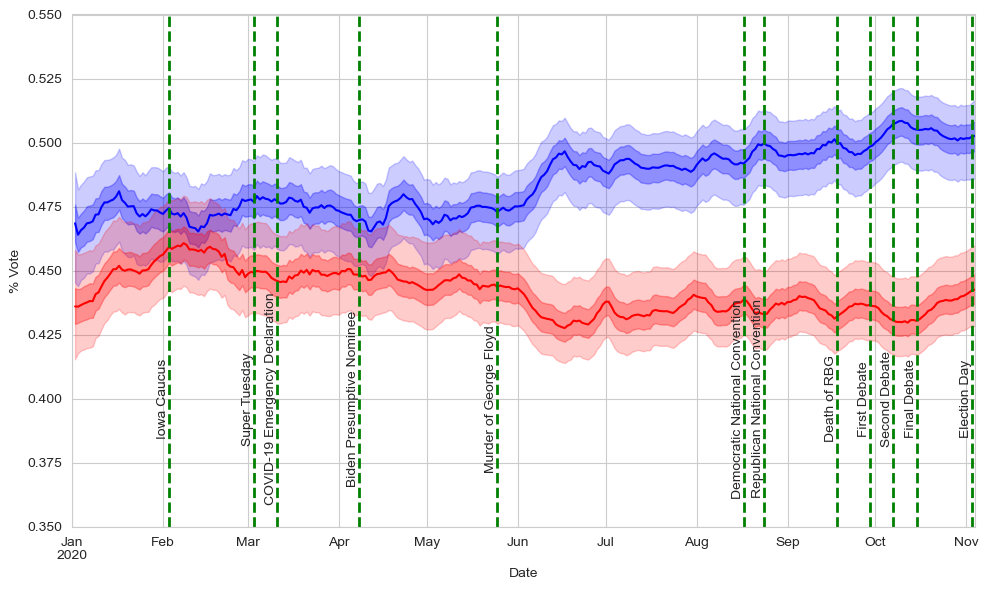

In [648]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].rolling(window='7D').mean().plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].rolling(window='7D').mean().ffill(), df_day_97[f"{graph_state}_dem"].rolling(window='7D').mean().ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].rolling(window='7D').mean().ffill(), df_day_75[f"{graph_state}_dem"].rolling(window='7D').mean().ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].rolling(window='7D').mean().plot(color='red', label='GOP Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].rolling(window='7D').mean().ffill(), df_day_97[f"{graph_state}_gop"].rolling(window='7D').mean().ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].rolling(window='7D').mean().ffill(), df_day_75[f"{graph_state}_gop"].rolling(window='7D').mean().ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

df_day_mean[f"{graph_state}_oth"].rolling(window='7D').mean().plot(color='goldenrod', label='Other Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_oth"].rolling(window='7D').mean().ffill(), df_day_97[f"{graph_state}_oth"].rolling(window='7D').mean().ffill(), color='goldenrod', alpha=0.2, label='OTH 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_oth"].rolling(window='7D').mean().ffill(), df_day_75[f"{graph_state}_oth"].rolling(window='7D').mean().ffill(), color='goldenrod', alpha=0.3, label='OTH 50% HDI')

#dem_votes = df.set_index('date').query(f"state == '{graph_state}'")["DEM"]
#gop_votes = df.set_index('date').query(f"state == '{graph_state}'")["GOP"]

#ax.plot(dem_votes.index, dem_votes, "o", alpha=.5, markersize=3, color='blue', label="Poll Dem., %")
#ax.plot(gop_votes.index, gop_votes, "o", alpha=.5, markersize=3, color='red', label="Poll GOP %")
#ax.plot(oth_votes.index, oth_votes, "o", alpha=.5, markersize=3, color='goldenrod', label="Poll Other %")

# Set limits and labels
ax.set_ylim(0.35,.55)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 4))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
#ax.legend(loc='center left', bbox_to_anchor=(0, 0.5))
#ax.set_title('2024 National Presidentential Polling')

events = [
            (dt.datetime(2020,  3, 11), 'COVID-19 Emergency Declaration'),
            (dt.datetime(2020,  3,  3), 'Super Tuesday'),
            (dt.datetime(2020,  4,  8), 'Biden Presumptive Nominee'),
            (dt.datetime(2020,  5, 25), 'Murder of George Floyd'),
            (dt.datetime(2020,  8, 17), 'Democratic National Convention'),
            (dt.datetime(2020,  8, 24), 'Republican National Convention'),
            (dt.datetime(2020,  9, 18), 'Death of RBG'),
            (dt.datetime(2020,  9, 29), 'First Debate'),
            (dt.datetime(2020, 10,  7), 'Second Debate'),
            (dt.datetime(2020, 10, 15), 'Final Debate'),
            (dt.datetime(2020, 11,  3), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.4, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=dt.datetime(2020, 2, 3), color='green', linestyle='--', linewidth=2)
plt.text(dt.datetime(2020, 2, 3), 0.4, 'Iowa Caucus', rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

#ax.plot(dt.datetime(2020, 11, 3), .5131, "<", markersize=25, color='blue', alpha=1)
#ax.plot(dt.datetime(2020, 11, 3), .4685, "<", markersize=25, color='red', alpha=1)

plt.tight_layout()
plt.savefig('2way_enight_natpoll.png')

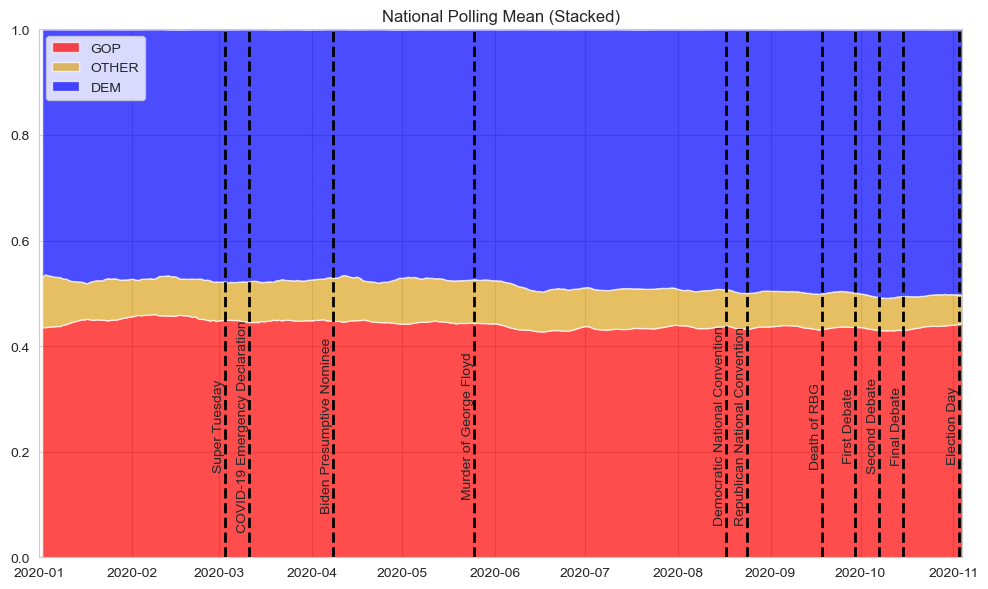

In [649]:
graph_state = 'US'

rolling_mean = (
    df_day_mean[[f"{graph_state}_gop", f"{graph_state}_oth", f"{graph_state}_dem"]]
    .sort_index()  # Ensure the index is sorted
    .rolling(window='7D')
    .mean()
    .reset_index()[["date", f"{graph_state}_gop", f"{graph_state}_oth", f"{graph_state}_dem"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 6))

ax.stackplot(
    rolling_mean.date,
    rolling_mean[f"{graph_state}_gop"].values,
    rolling_mean[f"{graph_state}_oth"].values,
    rolling_mean[f"{graph_state}_dem"].values,
    labels=["GOP", "OTHER", "DEM"],
    colors=['red', 'goldenrod', 'blue'],
    alpha=0.7,
)

ax.set_ylim(0, 1)  # Adjusted to fit the stacked plot
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 4))
ax.set_title("National Polling Mean (Stacked)")
ax.legend(loc='upper left')

events = [
            (dt.datetime(2020,  3, 11), 'COVID-19 Emergency Declaration'),
            (dt.datetime(2020,  3,  3), 'Super Tuesday'),
            (dt.datetime(2020,  4,  8), 'Biden Presumptive Nominee'),
            (dt.datetime(2020,  5, 25), 'Murder of George Floyd'),
            (dt.datetime(2020,  8, 17), 'Democratic National Convention'),
            (dt.datetime(2020,  8, 24), 'Republican National Convention'),
            (dt.datetime(2020,  9, 18), 'Death of RBG'),
            (dt.datetime(2020,  9, 29), 'First Debate'),
            (dt.datetime(2020, 10,  7), 'Second Debate'),
            (dt.datetime(2020, 10, 15), 'Final Debate'),
            (dt.datetime(2020, 11,  3), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='black', linestyle='--', linewidth=2)
    plt.text(date, 0.25, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

plt.tight_layout()
plt.savefig('stacked.png')

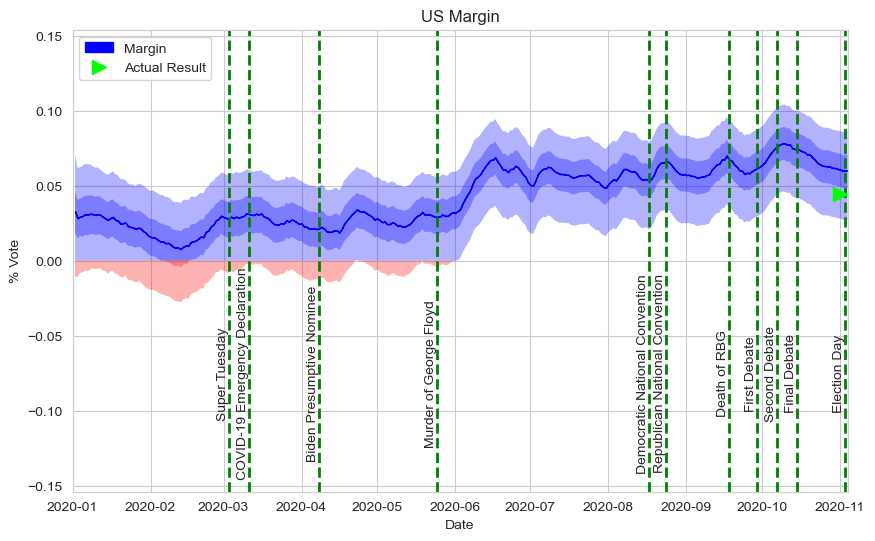

In [650]:
graph_state = 'US'

# Assuming df_day_mean, df_day_97, df_day_03, df_day_75, and df_day_25 are DataFrames
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the rolling means for each DataFrame and ensure no NaNs
mean_rolling = df_day_mean[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_03_rolling = df_day_03[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_97_rolling = df_day_97[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_25_rolling = df_day_25[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_75_rolling = df_day_75[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()

#dem_votes = df.set_index('date').query(f"state == '{graph_state}'")["DEM"] - df.set_index('date').query(f"state == '{graph_state}'")["GOP"]

#ax.plot(dem_votes.index, dem_votes, "o", alpha=.5, markersize=1, color='black', label="Polls")

# Plot 94% HDI

plt.fill_between(df_day_mean.index, 
                 np.maximum(0,hdi_03_rolling), 
                 np.maximum(hdi_97_rolling,0),
                 where=hdi_97_rolling > 0, 
                 color='blue', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.maximum(0,hdi_25_rolling), 
                 np.maximum(hdi_75_rolling,0), 
                 where=hdi_75_rolling > 0, 
                 color='blue', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.maximum(0,mean_rolling), 
                 np.maximum(mean_rolling,0), 
                 where=mean_rolling > 0, 
                 color='blue', alpha=1, label='Margin')

plt.fill_between(df_day_mean.index, 
                 np.minimum(0,hdi_03_rolling), 
                 np.minimum(hdi_97_rolling,0),
                 where=hdi_03_rolling < 0, 
                 color='red', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.minimum(0,hdi_25_rolling), 
                 np.minimum(hdi_75_rolling,0), 
                 where=hdi_25_rolling < 0, 
                 color='red', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.minimum(0,mean_rolling), 
                 np.minimum(mean_rolling,0), 
                 where=mean_rolling < 0, 
                 color='red', alpha=1)

# Set axis limits and labels
y_res = np.maximum((min(hdi_03_rolling)-.05)*-1, max(hdi_97_rolling)+.05)
ax.set_ylim(-y_res, y_res)
ax.set_xlim(dt.datetime(2020, 1, 1), dt.datetime(2020, 11, 4))

events = [
            (dt.datetime(2020,  3, 11), 'COVID-19 Emergency Declaration'),
            (dt.datetime(2020,  3,  3), 'Super Tuesday'),
            (dt.datetime(2020,  4,  8), 'Biden Presumptive Nominee'),
            (dt.datetime(2020,  5, 25), 'Murder of George Floyd'),
            (dt.datetime(2020,  8, 17), 'Democratic National Convention'),
            (dt.datetime(2020,  8, 24), 'Republican National Convention'),
            (dt.datetime(2020,  9, 18), 'Death of RBG'),
            (dt.datetime(2020,  9, 29), 'First Debate'),
            (dt.datetime(2020, 10,  7), 'Second Debate'),
            (dt.datetime(2020, 10, 15), 'Final Debate'),
            (dt.datetime(2020, 11,  3), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, -0.075, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.plot(dt.datetime(2020, 11, 1), .0446, ">", markersize=10, color='lime', alpha=1, label="Actual Result")

ax.set_title(f'{graph_state} Margin')
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')

plt.savefig(f'{graph_state}_margin.png')
ax.legend()

In [651]:
# List of states to loop over
state_loop = ['TX', 'CA', 'MN', 'MI', 'FL', 'GA', 'US','WI','PA','AZ','NV','NC', 'NY', 'OH']

# Loop over each state
for state in state_loop:
    graph_state = state
    
    # Create a new figure for each state
    plt.figure(figsize=(10, 6))
    
    # Define the bin edges, ensuring that they align perfectly
    bin_edges = np.arange(-0.3, 0.31, 0.01)
    
    # Plot the histogram using the pre-defined bins
    ax = sns.histplot(df_results[f"{graph_state}_margin"], bins=bin_edges, kde=False, stat="probability")
    
    # Get patches from the Axes
    for patch in ax.patches:
        # Get x midpoint of bar
        x = patch.get_x() + 0.5 * patch.get_width()
        
        # Set bar color based on x
        if x < 0:
            patch.set_facecolor('red')
        elif x > 0:
            patch.set_facecolor('blue')
        elif x == 0:
            patch.set_facecolor('lime')
    
    # Add titles and labels
    plt.title(f'2020 - {state} Margin')
    plt.xlabel('Democratic Margin')
    plt.xlim(-0.3, 0.3)
    plt.ylabel('Probability')
        
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'2way_enight_{state.lower()}.png')
    
    # Close the figure to avoid overlapping
    plt.close()


In [652]:
df_winner = pd.DataFrame(columns=states)

for state in states:
    # Get values for the current state
    dem_votes = df_results[f"{state}_dem"]
    gop_votes = df_results[f"{state}_gop"]
    
    # Compare votes and determine winner
    df_winner[state] = pd.Series(
        ["dem" if dem_votes[i] > gop_votes[i]
         else "gop" if gop_votes[i] > dem_votes[i]
         else "tie"
         for i in range(len(df_results))]
    )

In [653]:
df_state['state_code'][~df_state['state_code'].isin(df_winner.columns)]

32    NE-3
Name: state_code, dtype: object

In [654]:
df_winner[['NE-3']] = 'gop'

state_order = df_state['state_code'].to_list

In [655]:
df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/586220177.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/586220177.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})


In [656]:
df_ec = pd.DataFrame()
df_ec['dem'] = df_winner_dem.mul(df_state[['state_code', 'electoral_2024']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['gop'] = df_winner_gop.mul(df_state[['state_code', 'electoral_2024']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['dem_pop'] = df_winner_dem['US']
df_ec['gop_pop'] = df_winner_gop['US']
df_ec['dem_ec'] = np.where(df_ec['dem'] >= 270, 1, 0)
df_ec['gop_ec'] = np.where(df_ec['gop'] >= 270, 1, 0)
df_ec['tie_ec'] = np.where(df_ec['dem'] == 269, 1, 0)

In [657]:
# Calculate the total number of rows
total_rows = len(df_ec)

# Calculate the number of rows greater than, equal to, and lower than 270
greater_than_270 = len(df_ec[df_ec['dem'] > 269])
equal_to_270 = len(df_ec[df_ec['dem'] == 269])
lower_than_270 = len(df_ec[df_ec['dem'] < 269])

# Calculate the percentages
percent_greater_than_270 = (greater_than_270 / total_rows) * 100
percent_equal_to_270 = (equal_to_270 / total_rows) * 100
percent_lower_than_270 = (lower_than_270 / total_rows) * 100

percent_greater_than_270, percent_equal_to_270, percent_lower_than_270

(95.6, 0.0, 4.3999999999999995)

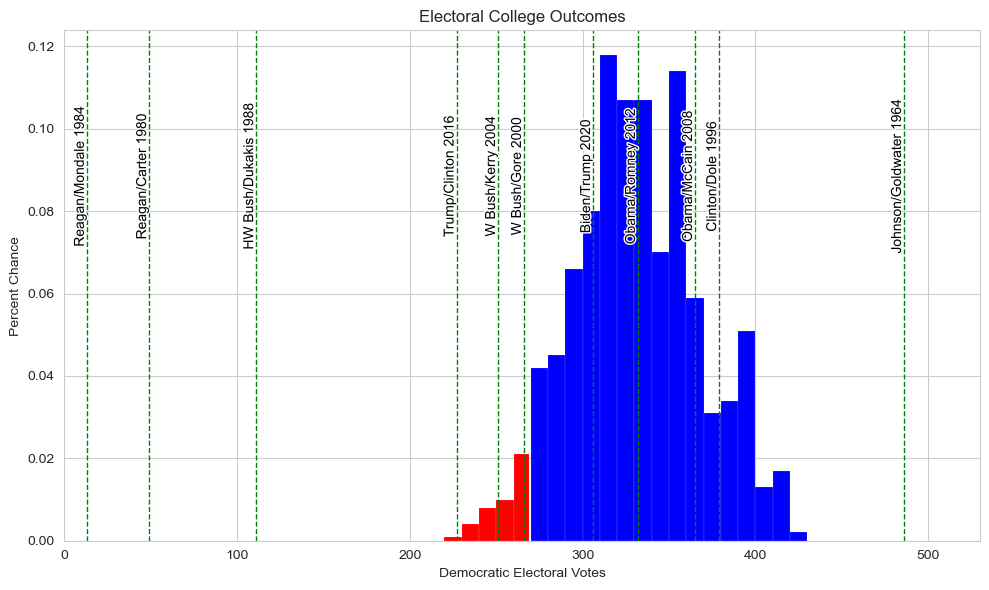

In [658]:
plt.figure(figsize=(10, 6))

bins = list(range(0, 269, 10)) + [269] + list(range(270, 540, 10))

# Use sns.histplot to plot the histogram
ax = sns.histplot(df_ec['dem'], bins=bins, kde=False, stat="probability")

# Get patches from the Axes
max_height = max([patch.get_height() for patch in ax.patches])

# Get the lowest and highest x values from the histogram bars
lowest_bar = min([patch.get_x() for patch in ax.patches])
highest_bar = max([patch.get_x() + patch.get_width() for patch in ax.patches])

# Get patches from the Axes
for patch in ax.patches:
    # Get x midpoint of bar
    x = patch.get_x() #+ 0.5 * patch.get_width()
    
    # Set bar color based on x
    if x < 269:
        patch.set_facecolor('red')
    elif x > 269:
        patch.set_facecolor('blue')
    elif x == 269:
        patch.set_facecolor('lime')
    else:
        patch.set_facecolor('lime')

# Adding titles and labels
#plt.title('2024 Election Night - Electoral College Results')
plt.title('Electoral College Outcomes')
plt.xlabel('Democratic Electoral Votes')
plt.xlim(lowest_bar, highest_bar)
plt.ylabel('Percent Chance')

events = [
    (13, 'Reagan/Mondale 1984'),
    (49, 'Reagan/Carter 1980'),
    (111, 'HW Bush/Dukakis 1988'),
    (227, 'Trump/Clinton 2016'),
    (251, 'W Bush/Kerry 2004'),
    (266, 'W Bush/Gore 2000'),
    (306, 'Biden/Trump 2020'),
    (332, 'Obama/Romney 2012'),
    (365, 'Obama/McCain 2008'),
    (379, 'Clinton/Dole 1996'),
    (486, 'Johnson/Goldwater 1964')
]

label_position = 3/4 * max_height

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=1)
    text = plt.text(date, label_position, event, rotation=90, verticalalignment='center', 
                    horizontalalignment='right', fontsize=10, color='black')
    
    # Add white outline to the text
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                           path_effects.Normal()])

plt.tight_layout()
# Display the plot
plt.savefig('2way_enight_ec.png')

In [706]:
df_margin = pd.DataFrame(columns=states)
df_gop = pd.DataFrame(columns=states)
df_dem = pd.DataFrame(columns=states)
df_oth = pd.DataFrame(columns=states)

for state in states:
    df_margin[state] = df_results[f"{state}_margin"]
    df_gop[state] = df_results[f"{state}_gop"]
    df_dem[state] = df_results[f"{state}_dem"]

df_mean = pd.DataFrame(columns=parties)
df_mean['dem'] = df_dem.mean()
df_mean['gop'] = df_gop.mean()
df_mean['margin'] = df_margin.mean()

In [707]:
df_win_pct = pd.DataFrame()
df_win_pct['dem'] = df_winner_dem.mean(axis=0)
df_win_pct['gop'] = df_winner_gop.mean(axis=0)

In [708]:
print("Safe D: ")
print(df_win_pct.query("dem >= .98").index.sort_values().values)
print("Likely D: ")
print(df_win_pct.query("(dem < .98) and (dem >= .75)").index.sort_values().values)
print("Leans D: ")
print(df_win_pct.query("(dem < .75) and (dem >= .6)").index.sort_values().values)
print("Tilt D: ")
print(df_win_pct.query("(dem < .6) and (dem >= .5)").index.sort_values().values)
print("Tilt R: ")
print(df_win_pct.query("(gop < .6) and (gop >= .5)").index.sort_values().values)
print("Leans R: ")
print(df_win_pct.query("(gop < .75) and (gop >= .6)").index.sort_values().values)
print("Likely R: ")
print(df_win_pct.query("(gop < .98) and (gop >= .75)").index.sort_values().values)
print("Safe R: ")
print(df_win_pct.query("gop >= .98").index.sort_values().values)

Safe D: 
['CA' 'CO' 'CT' 'DC' 'DE' 'HI' 'IL' 'MA' 'MD' 'ME' 'ME-1' 'MN' 'NH' 'NJ'
 'NM' 'NY' 'OR' 'RI' 'US' 'VA' 'VT' 'WA']
Likely D: 
['MI' 'NE-2' 'PA' 'WI']
Leans D: 
['AZ' 'GA' 'NC' 'NV']
Tilt D: 
['FL' 'ME-2']
Tilt R: 
[]
Leans R: 
['IA' 'NE-1']
Likely R: 
['OH' 'TX']
Safe R: 
['AK' 'AL' 'AR' 'ID' 'IN' 'KS' 'KY' 'LA' 'MO' 'MS' 'MT' 'ND' 'NE' 'NE-3'
 'OK' 'SC' 'SD' 'TN' 'UT' 'WV' 'WY']


In [709]:
pct_dem_wo_pop = 100*len(df_ec.query("(gop_pop == 1) & (dem > 269)"))/len(df_ec)
pct_gop_wo_pop = 100*len(df_ec.query("(dem_pop == 1) & (gop > 269)"))/len(df_ec)

print("% Chance of a Win in Electoral College")
print("-------------------------------------")
print(" Democrats:   " + f"{round(percent_greater_than_270,2):6.2f}" + "%")
print(" Tie:         " + f"{round(percent_equal_to_270,2):6.2f}" + "%")
print(" Republicans: " + f"{round(percent_lower_than_270,2):6.2f}" + "%")
print()
print("% Chance of a Win without Popular Vote")
print("-------------------------------------")
print(" Democrats:   " + f"{round(pct_dem_wo_pop,2):6.2f}" + "%")
print(" Republicans: " + f"{round(pct_gop_wo_pop,2):6.2f}" + "%")
print(" Total:       " + f"{round(pct_dem_wo_pop+pct_gop_wo_pop,2):6.2f}" + "%")
print()
print("% Chance of Popular Vote Win")
print("-------------------------------------")
print(" Democrats:   " + f"{round(df_winner_dem.US.mean()*100,2):6.2f}" + "%")
print(" Republicans: " + f"{round(df_winner_gop.US.mean()*100,2):6.2f}" + "%")
print()
print("Popular Vote Estimates")
print("-----------------------------")
print("  %  |  DEM  |  GOP  | Margin ")
print("  3% | "+ f"{df_dem.US.quantile(0.03) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.97) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.03) * 100 - df_gop.US.quantile(0.97) * 100, 2):6.2f}")
print(" 25% | "+ f"{df_dem.US.quantile(0.25) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.75) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.25) * 100 - df_gop.US.quantile(0.75) * 100, 2):6.2f}")
print(" 50% | "+ f"{df_dem.US.quantile(0.50) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.50) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.50) * 100 - df_gop.US.quantile(0.50) * 100, 2):6.2f}")
print(" 75% | "+ f"{df_dem.US.quantile(0.75) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.25) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.75) * 100 - df_gop.US.quantile(0.25) * 100, 2):6.2f}")
print(" 97% | "+ f"{df_dem.US.quantile(0.97) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.03) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.97) * 100 - df_gop.US.quantile(0.03) * 100, 2):6.2f}")

% Chance of a Win in Electoral College
-------------------------------------
 Democrats:    95.60%
 Tie:           0.00%
 Republicans:   4.40%

% Chance of a Win without Popular Vote
-------------------------------------
 Democrats:     0.00%
 Republicans:   4.30%
 Total:         4.30%

% Chance of Popular Vote Win
-------------------------------------
 Democrats:    99.90%
 Republicans:   0.10%

Popular Vote Estimates
-----------------------------
  %  |  DEM  |  GOP  | Margin 
  3% | 48.39 | 46.18 |  2.21
 25% | 49.57 | 44.91 |  4.66
 50% | 50.28 | 44.25 |  6.02
 75% | 50.87 | 43.66 |  7.21
 97% | 51.94 | 42.54 |  9.40


In [710]:
margin_and_ec = pd.DataFrame()
margin_and_ec['pop'] = df_results.US_margin
margin_and_ec['ec'] = df_ec.dem - df_ec.gop

margin_and_ec = margin_and_ec.groupby('ec').agg(
    count=('pop', 'size'),   # Count the occurrences of each unique combination of rows
    pop=('pop', 'mean')  # Calculate the mean of the 'margin' column
).reset_index().sort_values("count", ascending = False)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/1270919858.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/1270919858.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]


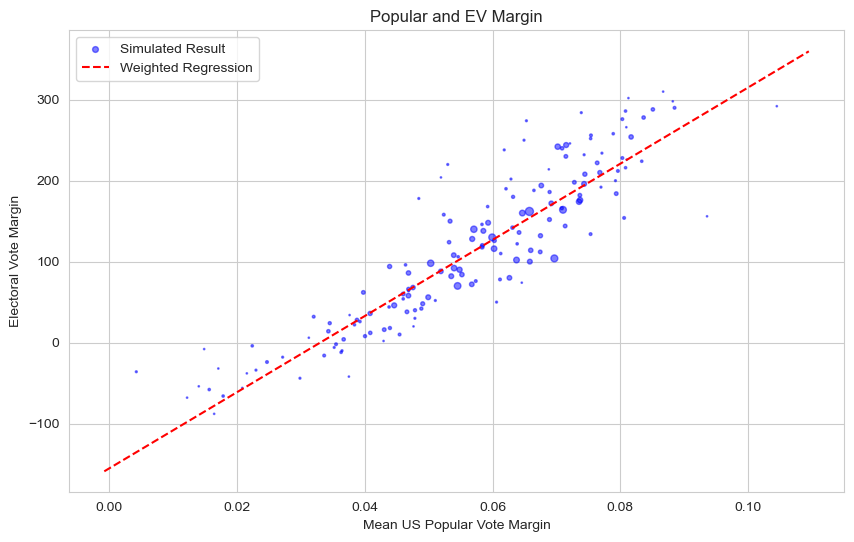

In [711]:
# Create scatter plot
plt.figure(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(margin_and_ec['pop'], margin_and_ec['ec'], 
            s=margin_and_ec['count'], color='blue', alpha=0.5, label='Simulated Result')

# Perform weighted linear regression using 'Count' as the weight
X = margin_and_ec['pop']
y = margin_and_ec['ec']
weights = margin_and_ec['count']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Perform weighted least squares regression
wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

# Extract regression line parameters
slope = results.params[1]
intercept = results.params[0]

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

# Add labels and title
plt.xlabel('Mean US Popular Vote Margin')
plt.ylabel('Electoral Vote Margin')
plt.title('Popular and EV Margin')

# Add legend
plt.legend()

# Show plot
plt.savefig('margin_needed.png')

In [712]:
-results.params[0]/results.params[1]

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/2850610987.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  -results.params[0]/results.params[1]


0.033027578705076686

In [713]:
df_winp = df_results.filter(regex='_margin$')
df_winp.columns = df_winp.columns.str.replace('_margin$', '', regex=True)
df_winp = df_winp.map(lambda x: 0 if x < 0 else 1)

df_winp = df_winp.merge(df_ec[['dem_ec','dem', 'gop']], left_index=True, right_index=True, how='left')
df_winp['us_margin'] = df_dem.US-df_gop.US

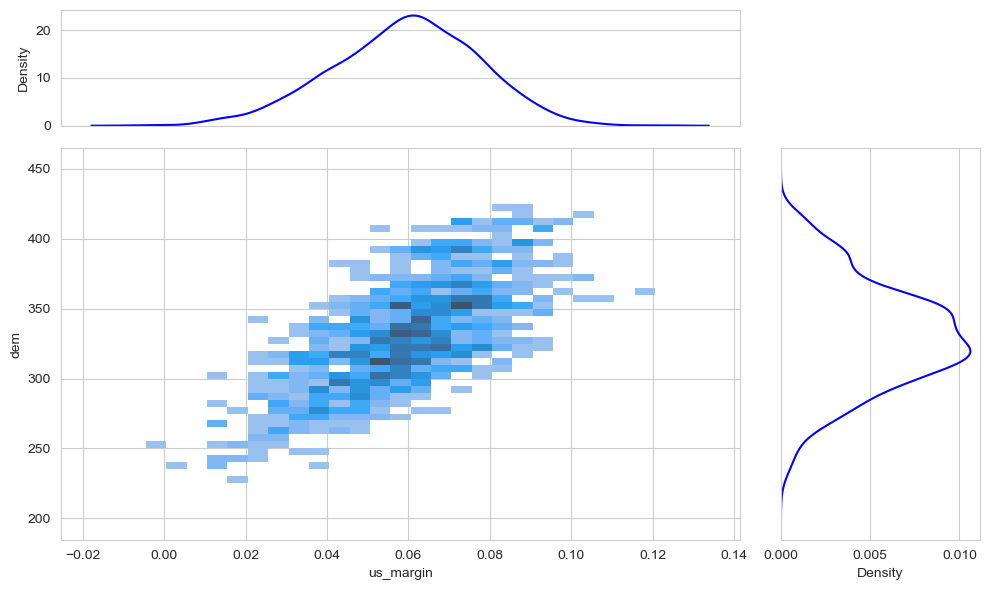

In [714]:
from matplotlib.gridspec import GridSpec

# Example Data (replace df_winp with your actual dataframe)
# df_winp = ...

# Create the figure with subplots
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(4, 4, figure=fig)

# Main 2D histogram (place at center)
ax_main = fig.add_subplot(gs[1:4, 0:3])
sns.histplot(x=df_winp.us_margin, y=df_winp.dem, binwidth=(.005,5), ax=ax_main)
#ax_main.axhline(y=306, color='green', linestyle='--', label='2020 Actual Result')
#ax_main.axvline(x=.0446, color='green', linestyle='--')

# KDE on top (for us_margin)
ax_top = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
sns.kdeplot(x=df_winp.us_margin, ax=ax_top, color='blue')
#ax_top.axvline(x=.0446, color='green', linestyle='--')  # Extend vertical dashed line to top KDE
ax_top.get_xaxis().set_visible(False)  # Hide x-axis labels

# KDE on the right (for dem)
ax_right = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
sns.kdeplot(y=df_winp.dem, ax=ax_right, color='blue')
#ax_right.axhline(y=306, color='green', linestyle='--')  # Extend horizontal dashed line to right KDE
ax_right.get_yaxis().set_visible(False)  # Hide y-axis labels

# Adjust layout
plt.tight_layout()

In [726]:
df_2020 = pd.read_csv("../Data/clean/2020_election_results.csv")

df_margin = pd.DataFrame()
df_margin['hdi_03'] = (df_dem - df_gop).quantile(0.03)
df_margin['hdi_25'] = (df_dem - df_gop).quantile(0.25)
df_margin['hdi_mean'] = (df_dem - df_gop).quantile(0.50)
df_margin['hdi_75'] = (df_dem - df_gop).quantile(0.75)
df_margin['hdi_97'] = (df_dem - df_gop).quantile(0.97)

df_margin['state_code'] = df_dem.columns.values
df_margin = df_margin.merge(df_win_pct,left_index=True, right_index=True)
df_margin = df_margin.merge(df_2020[['margin','State']].set_index('State'),left_index=True, right_index=True)

df_margin['scale'] = 10

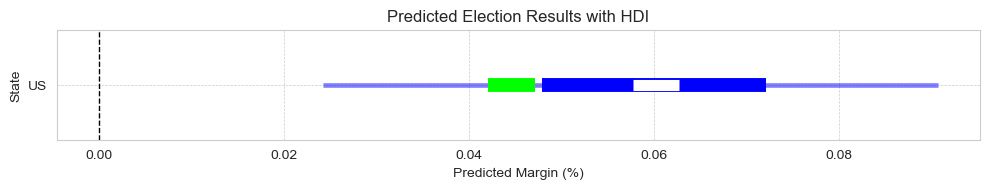

In [727]:
# Sort the dataframe by the absolute value of 'hdi_mean'
chart_df = df_margin.query("state_code == 'US'").sort_values(by='hdi_mean')
scale_factor = 1

# Create custom y-axis positions based on cumulative electoral votes
cumulative_votes = np.cumsum(chart_df['scale'] * scale_factor)
y_positions = cumulative_votes - (chart_df['scale'] * scale_factor / 2)

# Set up the figure
plt.figure(figsize=(10, 2))

# Plot each segment of the 50% HDI interval
for i, row in chart_df.iterrows():
    plt.hlines(y=y_positions[i], xmin=row['hdi_mean']-.0025, xmax=row['hdi_mean']+.0025, color='white', alpha=1, linewidth=row['scale'] * scale_factor*.8, zorder=5)
    plt.hlines(y=y_positions[i], xmin=row['margin']-.0025, xmax=row['margin']+.0025, color='lime', alpha=1, linewidth=row['scale'] * scale_factor, zorder=5)
    # If hdi_75 is above 0, split the interval at 0
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['scale'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['scale'] * scale_factor, zorder=3)
    # If hdi_97 is above 0, split the interval at 0
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)

# Add a vertical line at zero for reference
plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

# Set the y-axis labels to the state codes
plt.yticks(y_positions, chart_df['state_code'])

# Labels and title
plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Predicted Election Results with HDI')

# Improve grid appearance
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()

# Display the plot
plt.savefig('all_states.png')

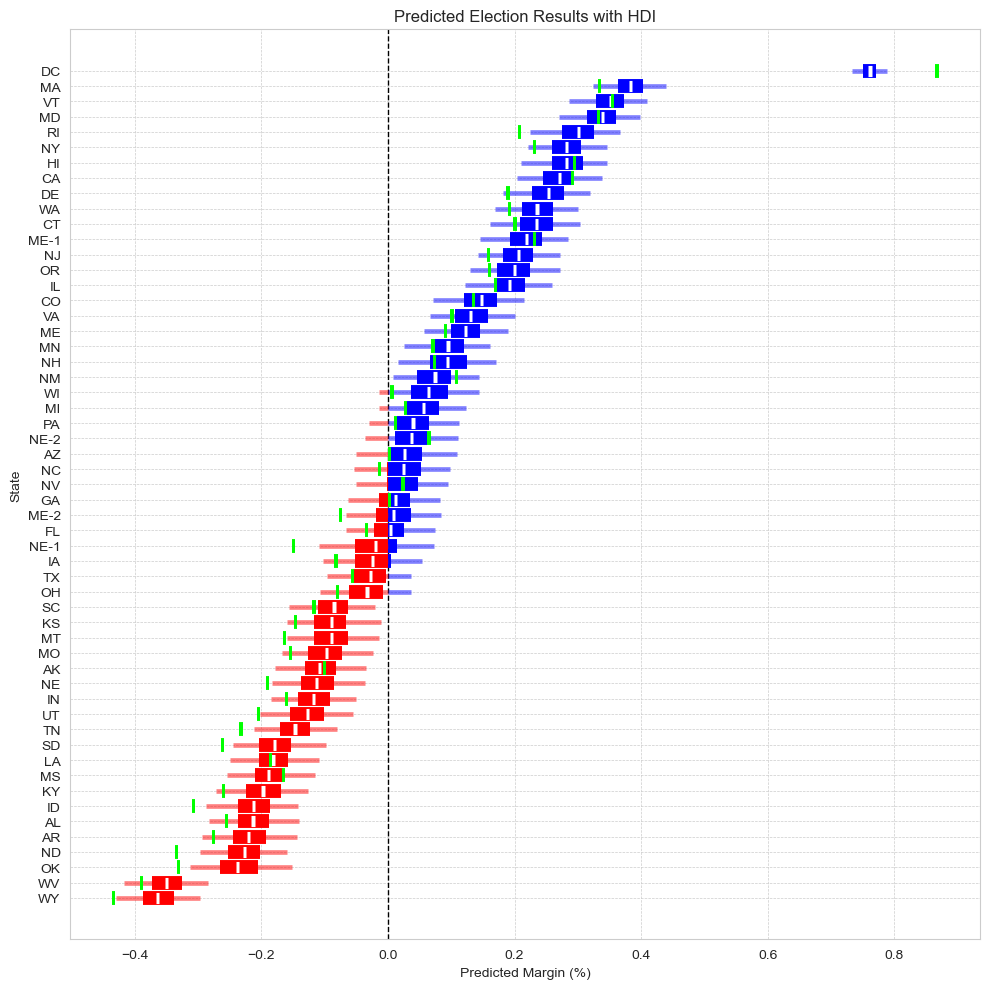

In [730]:
# Sort the dataframe by the absolute value of 'hdi_mean'
chart_df = df_margin.query("state_code != 'US'").sort_values(by='hdi_mean')
scale_factor = 1

# Create custom y-axis positions based on cumulative electoral votes
cumulative_votes = np.cumsum(chart_df['scale'] * scale_factor)
y_positions = cumulative_votes - (chart_df['scale'] * scale_factor / 2)

# Set up the figure
plt.figure(figsize=(10, 10))

# Plot each segment of the 50% HDI interval
for i, row in chart_df.iterrows():
    plt.hlines(y=y_positions[i], xmin=row['hdi_mean']-.0025, xmax=row['hdi_mean']+.0025, color='white', alpha=1, linewidth=row['scale'] * scale_factor*.8, zorder=5)
    plt.hlines(y=y_positions[i], xmin=row['margin']-.0025, xmax=row['margin']+.0025, color='lime', alpha=1, linewidth=row['scale'] * scale_factor, zorder=5)
    # If hdi_75 is above 0, split the interval at 0
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['scale'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['scale'] * scale_factor, zorder=3)
    # If hdi_97 is above 0, split the interval at 0
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)

# Add a vertical line at zero for reference
plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

# Set the y-axis labels to the state codes
plt.yticks(y_positions, chart_df['state_code'])

# Labels and title
plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Predicted Election Results with HDI')

# Improve grid appearance
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()

# Display the plot
plt.savefig('all_states.png')

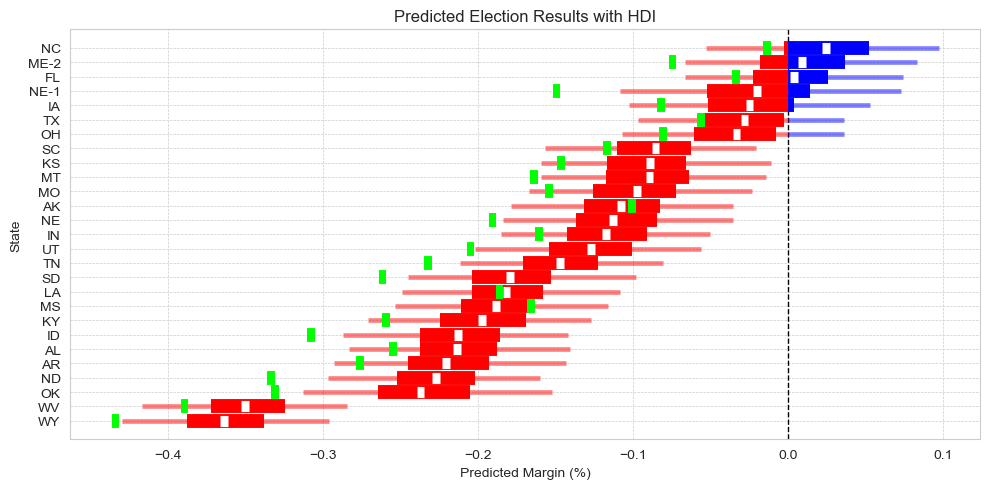

In [731]:
## Sort the dataframe by the absolute value of 'hdi_mean'
chart_df = df_margin.query("state_code in ('NE-3','WY','WV','ND','OK','ID','AR','SD','KY','AL','TN','UT','NE','LA','MS','MT','IN','MO','NE-1','KS','SC','AK','IA','OH','ME-2','TX','FL','NC')").sort_values(by='hdi_mean')
scale_factor = 1

# Create custom y-axis positions based on cumulative electoral votes
cumulative_votes = np.cumsum(chart_df['scale'] * scale_factor)
y_positions = cumulative_votes - (chart_df['scale'] * scale_factor / 2)

# Set up the figure
plt.figure(figsize=(10, 5))

# Plot each segment of the 50% HDI interval
for i, row in chart_df.iterrows():
    plt.hlines(y=y_positions[i], xmin=row['hdi_mean']-.0025, xmax=row['hdi_mean']+.0025, color='white', alpha=1, linewidth=row['scale'] * scale_factor*.8, zorder=5)
    plt.hlines(y=y_positions[i], xmin=row['margin']-.0025, xmax=row['margin']+.0025, color='lime', alpha=1, linewidth=row['scale'] * scale_factor, zorder=5)
    # If hdi_75 is above 0, split the interval at 0
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['scale'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['scale'] * scale_factor, zorder=3)
    # If hdi_97 is above 0, split the interval at 0
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)

# Add a vertical line at zero for reference
plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

# Set the y-axis labels to the state codes
plt.yticks(y_positions, chart_df['state_code'])

# Labels and title
plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Predicted Election Results with HDI')

# Improve grid appearance
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()

# Display the plot
plt.savefig('all_states.png')

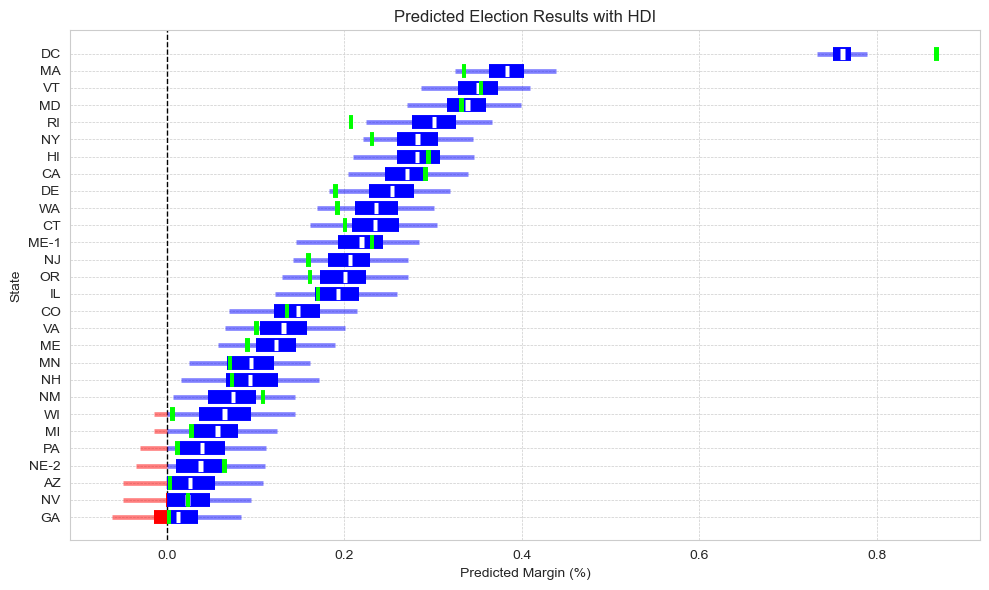

In [732]:
# Sort the dataframe by the absolute value of 'hdi_mean'
chart_df = df_margin.query("state_code in ('GA','AZ','WI','PA','NV','MI','NE-2','MN','NH','ME','VA','NM','CO','NJ','OR','IL','DE','WA','CT','RI','ME-1','NY','CA','HI','MD','MA','VT','DC')").sort_values(by='hdi_mean')
scale_factor = 1

# Create custom y-axis positions based on cumulative electoral votes
cumulative_votes = np.cumsum(chart_df['scale'] * scale_factor)
y_positions = cumulative_votes - (chart_df['scale'] * scale_factor / 2)

# Set up the figure
plt.figure(figsize=(10, 6))

# Plot each segment of the 50% HDI interval
for i, row in chart_df.iterrows():
    plt.hlines(y=y_positions[i], xmin=row['hdi_mean']-.0025, xmax=row['hdi_mean']+.0025, color='white', alpha=1, linewidth=row['scale'] * scale_factor*.8, zorder=5)
    plt.hlines(y=y_positions[i], xmin=row['margin']-.0025, xmax=row['margin']+.0025, color='lime', alpha=1, linewidth=row['scale'] * scale_factor, zorder=5)
    # If hdi_75 is above 0, split the interval at 0
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['scale'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['scale'] * scale_factor, zorder=3)
    # If hdi_97 is above 0, split the interval at 0
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)

# Add a vertical line at zero for reference
plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

# Set the y-axis labels to the state codes
plt.yticks(y_positions, chart_df['state_code'])

# Labels and title
plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Predicted Election Results with HDI')

# Improve grid appearance
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()

# Display the plot
plt.savefig('all_states.png')

In [733]:
grouped_df = df_winp.groupby(list(df_winp.columns[1:-1])).agg(
    count=('us_margin', 'size'),   # Count the occurrences of each unique combination of rows
    margin_mean=('us_margin', 'mean')  # Calculate the mean of the 'margin' column
).reset_index().sort_values("count", ascending = False)
grouped_df.to_excel('df_value_counts.xlsx', index=False)

def conditional_probability(df, col_A, col_B):
    # Joint probability of A and B both being true (P(A ∩ B))
    P_A_and_B = ((df[col_A] == 1) & (df[col_B] == 1)).mean()
    
    # Probability of B being true (P(B))
    P_B = (df[col_B] == 1).mean()
    
    # Conditional probability P(A | B)
    return P_A_and_B / P_B if P_B != 0 else 0

# Create a table of conditional probabilities for each pair of columns
conditional_prob_table = pd.DataFrame(index=df_winp.iloc[:, :-2].columns, columns=df_winp.iloc[:, :-2].columns)

for col_A in df_winp.iloc[:, :-3].columns:
    for col_B in df_winp.iloc[:, :-2].columns:
        conditional_prob_table.loc[col_A, col_B] = conditional_probability(df_winp.iloc[:, :-2], col_A, col_B)

# Convert to float for easier viewing
conditional_prob_table = conditional_prob_table.astype(float)

selected_states = df_winp.loc[:, (df_winp.mean(axis=0) >= 0.01) & (df_winp.mean(axis=0) <= .99)].iloc[:,:-1].columns

conditional_prob_table.loc[selected_states, selected_states]

,FL,IA,PA,NV,GA,NE-2,MT,ME-2,AZ,NC,TX,WI,OH,NM,NH,MI,KS,NE-1,dem_ec
FL,1.000000,0.596429,0.565774,0.573770,0.582665,0.572289,0.400000,0.559380,0.576769,0.571233,0.630435,0.546227,0.612022,0.542304,0.542047,0.540805,0.769231,0.585434,0.561715
IA,0.310987,1.000000,0.296857,0.316940,0.327448,0.307229,0.466667,0.316695,0.308411,0.326027,0.421739,0.286929,0.366120,0.284404,0.283688,0.292709,0.538462,0.333333,0.289749
PA,0.905028,0.910714,1.000000,0.886612,0.892456,0.877108,1.000000,0.898451,0.885180,0.893151,0.908696,0.872476,0.918033,0.863405,0.862209,0.862894,1.000000,0.924370,0.888075
NV,0.782123,0.828571,0.755530,1.000000,0.784912,0.766265,1.000000,0.798623,0.766355,0.768493,0.808696,0.744952,0.775956,0.734964,0.736575,0.746464,1.000000,0.789916,0.753138
GA,0.675978,0.728571,0.647264,0.668033,1.000000,0.663855,0.933333,0.686747,0.670227,0.668493,0.717391,0.637620,0.743169,0.625892,0.629179,0.638738,1.000000,0.722689,0.648536
NE-2,0.884544,0.910714,0.847497,0.868852,0.884430,1.000000,1.000000,0.884682,0.867824,0.847945,0.891304,0.839532,0.896175,0.833843,0.835866,0.833515,1.000000,0.868347,0.844142
MT,0.011173,0.025000,0.017462,0.020492,0.022472,0.018072,1.000000,0.018933,0.018692,0.020548,0.017391,0.015940,0.027322,0.015291,0.015198,0.015234,0.076923,0.028011,0.015690
ME-2,0.605214,0.657143,0.607683,0.633880,0.640449,0.619277,0.733333,1.000000,0.619493,0.627397,0.647826,0.595112,0.699454,0.582059,0.585613,0.596300,0.923077,0.680672,0.599372
AZ,0.804469,0.825000,0.771828,0.784153,0.805778,0.783133,0.933333,0.798623,1.000000,0.808219,0.869565,0.766206,0.863388,0.752294,0.753799,0.764962,1.000000,0.801120,0.770921
NC,0.776536,0.850000,0.759022,0.766393,0.783307,0.745783,1.000000,0.788296,0.787717,1.000000,0.813043,0.744952,0.781421,0.734964,0.732523,0.749728,1.000000,0.823529,0.754184


In [734]:
df_winp.loc[:, (df_winp.mean(axis=0) >= 0.01) & (df_winp.mean(axis=0) <= .99)].iloc[:,:-1].corr()

,FL,IA,PA,NV,GA,NE-2,MT,ME-2,AZ,NC,TX,WI,OH,NM,NH,MI,KS,NE-1,dem_ec
FL,1.000000,0.074324,0.142433,0.121874,0.117727,0.156379,-0.033906,0.052853,0.137775,0.112887,0.102412,0.073905,0.071207,0.076430,0.088188,0.025705,0.053451,0.072377,0.231044
IA,0.074324,1.000000,0.092665,0.135969,0.135845,0.133998,0.051304,0.096238,0.109307,0.168559,0.172529,0.061628,0.090777,0.070474,0.071569,0.095345,0.066064,0.088508,0.101208
PA,0.142433,0.092665,1.000000,0.131123,0.123577,0.114971,0.049997,0.133485,0.129949,0.161351,0.078042,0.154642,0.080279,0.090942,0.080336,0.037693,0.046497,0.139959,0.389422
NV,0.121874,0.135969,0.131123,1.000000,0.153569,0.170940,0.074669,0.177126,0.133990,0.135478,0.094638,0.116785,0.046969,0.048091,0.090012,0.109994,0.069442,0.097433,0.222457
GA,0.117727,0.135845,0.123577,0.153569,1.000000,0.186273,0.079021,0.154891,0.168337,0.154352,0.106448,0.120473,0.117353,0.042878,0.111100,0.109381,0.089277,0.153272,0.245603
NE-2,0.156379,0.133998,0.114971,0.170940,0.186273,1.000000,0.055849,0.171419,0.173942,0.078553,0.089196,0.101346,0.083377,0.073513,0.136077,0.031517,0.051940,0.076068,0.175492
MT,-0.033906,0.051304,0.049997,0.074669,0.079021,0.055849,1.000000,0.038100,0.052463,0.075050,0.010752,0.030900,0.047978,0.017174,0.014163,0.006483,0.058466,0.079759,0.026474
ME-2,0.052853,0.096238,0.133485,0.177126,0.154891,0.171419,0.038100,1.000000,0.134768,0.154624,0.074023,0.114222,0.113623,0.015424,0.081465,0.104453,0.079569,0.150525,0.173569
AZ,0.137775,0.109307,0.129949,0.133990,0.168337,0.173942,0.052463,0.134768,1.000000,0.224576,0.151972,0.158480,0.124858,0.054582,0.096448,0.124000,0.066437,0.089569,0.235654
NC,0.112887,0.168559,0.161351,0.135478,0.154352,0.078553,0.075050,0.154624,0.224576,1.000000,0.102231,0.134502,0.054816,0.080348,0.049514,0.149677,0.069796,0.156976,0.253916


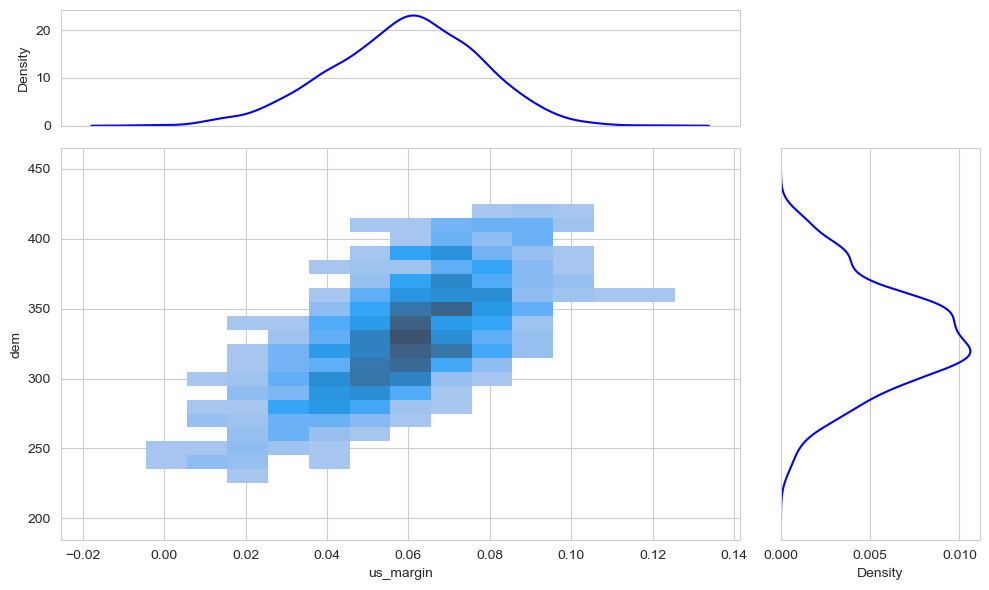

In [735]:
from matplotlib.gridspec import GridSpec

# Example Data (replace df_winp with your actual dataframe)
# df_winp = ...

# Create the figure with subplots
fig = plt.figure(figsize=(10, 6))
gs = GridSpec(4, 4, figure=fig)

# Main 2D histogram (place at center)
ax_main = fig.add_subplot(gs[1:4, 0:3])
sns.histplot(x=df_winp.us_margin, y=df_winp.dem, binwidth=(.01,10), ax=ax_main)
#ax_main.axhline(y=306, color='green', linestyle='--', label='2020 Actual Result')
#ax_main.axvline(x=.0446, color='green', linestyle='--')

# KDE on top (for us_margin)
ax_top = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
sns.kdeplot(x=df_winp.us_margin, ax=ax_top, color='blue')
#ax_top.axvline(x=.0446, color='green', linestyle='--')  # Extend vertical dashed line to top KDE
ax_top.get_xaxis().set_visible(False)  # Hide x-axis labels

# KDE on the right (for dem)
ax_right = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
sns.kdeplot(y=df_winp.dem, ax=ax_right, color='blue')
#ax_right.axhline(y=306, color='green', linestyle='--')  # Extend horizontal dashed line to right KDE
ax_right.get_yaxis().set_visible(False)  # Hide y-axis labels

# Adjust layout
plt.tight_layout()

In [736]:
df_margin['error'] =  df_margin.hdi_mean - df_margin.margin

df_margin = pd.merge(df_margin, pd.DataFrame(df.state.value_counts()),
         how="left",
         left_on='state_code',
         right_index=True)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/2937487817.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/2937487817.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/2937487817.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

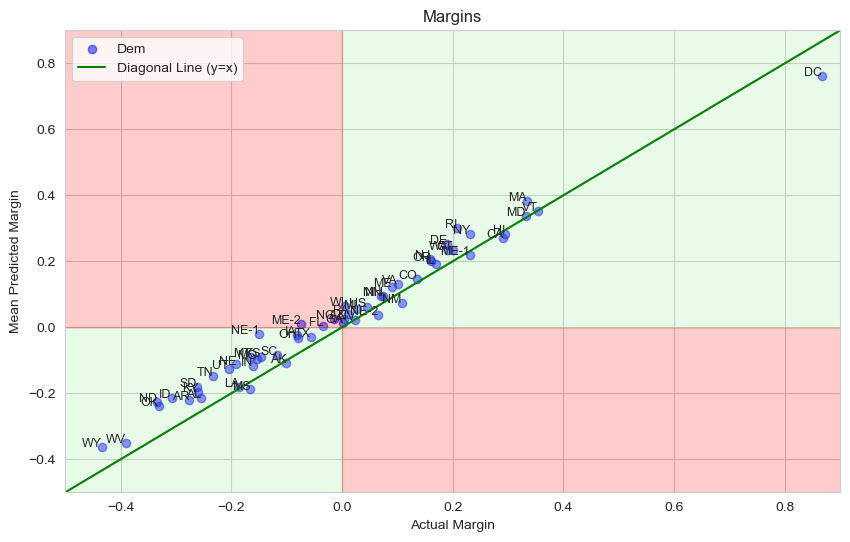

In [737]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], df_margin['hdi_mean'], 
            color='blue', alpha=0.5, label='Dem')

import statsmodels.api as sm
import scipy.stats as stats

# Perform weighted linear regression using 'Count' as the weight
X = df_margin['margin']
y = df_margin['hdi_mean']
weights = df_margin['count']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Perform weighted least squares regression
wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

# Extract regression line parameters
slope = results.params[1]
intercept = results.params[0]

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
#plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

# Add diagonal line (y = x)
plt.plot(x_vals, x_vals, color='green', linestyle='-', label='Diagonal Line (y=x)')

ax.set_xlim(-.5, .9)
ax.set_ylim(-.5, .9)

# Shade the quadrants
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=0, x2=1, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=-1, x2=0, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=-1, x2=0, color='red', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=0, x2=1, color='red', alpha=0.2)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['state_code']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['hdi_mean'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], df_margin['hdi_mean'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Mean Predicted Margin')
plt.title('Margins')

# Add legend
plt.legend()

# Show plot
plt.savefig('pres_2020_margins.png')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/3259135303.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_val = df_margin['margin'][i]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/3259135303.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val = df_margin['hdi_mean'][i]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/3259135303.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

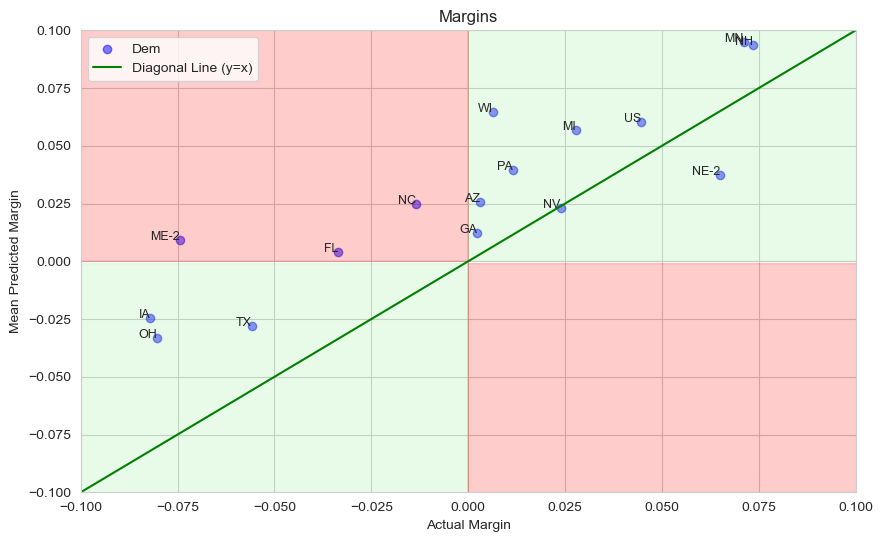

In [738]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], df_margin['hdi_mean'], 
            color='blue', alpha=0.5, label='Dem')

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals

# Add diagonal line (y = x)
plt.plot(x_vals, x_vals, color='green', linestyle='-', label='Diagonal Line (y=x)')

ax.set_xlim(-.1, .1)
ax.set_ylim(-.1, .1)

# Shade the quadrants
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=0, x2=1, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=-1, x2=0, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=-1, x2=0, color='red', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=0, x2=1, color='red', alpha=0.2)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['state_code']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['hdi_mean'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], df_margin['hdi_mean'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Mean Predicted Margin')
plt.title('Margins')

# Add legend
plt.legend()

# Show plot
plt.savefig('pres_2020_margins_zoom.png')

In [739]:
calc_slope = 1/slope
calc_intercept = intercept

In [740]:
calc_slope

1.1195758311132074

In [741]:
calc_intercept

0.031846051658947355

In [742]:
df_margin['mean_corrected'] = df_margin.hdi_mean*calc_slope-calc_intercept
df_margin['error_corrected'] =  df_margin.mean_corrected - df_margin.margin

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/2449989369.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/2449989369.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/2449989369.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

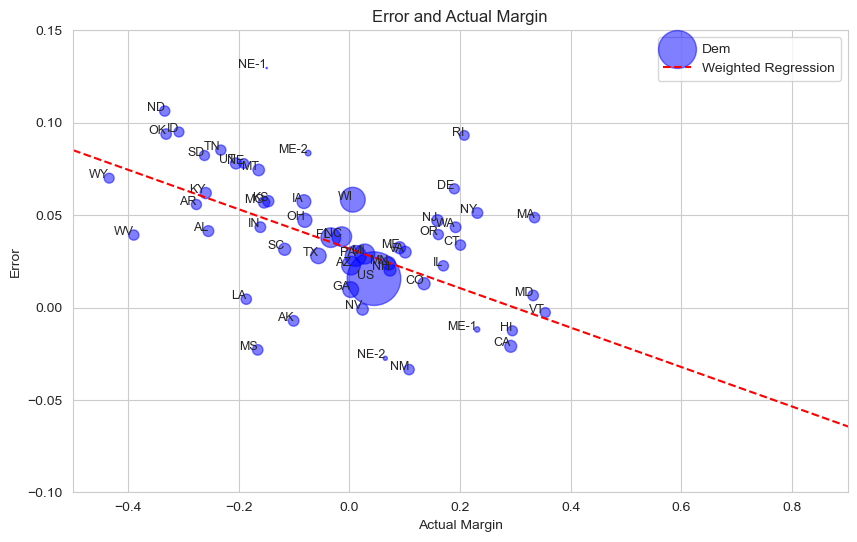

In [743]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], df_margin['error'], 
             s=df_margin['count'], color='blue', alpha=0.5, label='Dem')

# Perform weighted linear regression using 'Count' as the weight
X = df_margin['margin']
y = df_margin['error']
weights = df_margin['count']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Perform weighted least squares regression
wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

# Extract regression line parameters
slope = results.params[1]
intercept = results.params[0]

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

#ax.set_xlim(-.5, .9)
#ax.set_ylim(-.15, .15)

ax.set_xlim(-.5, .9)
ax.set_ylim(-.1, .15)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['state_code']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['error'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], df_margin['error'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Error')
plt.title('Error and Actual Margin')

# Add legend
plt.legend()

# Show plot
plt.savefig('pres_2020_error.png')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/1733731390.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/1733731390.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_36721/1733731390.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

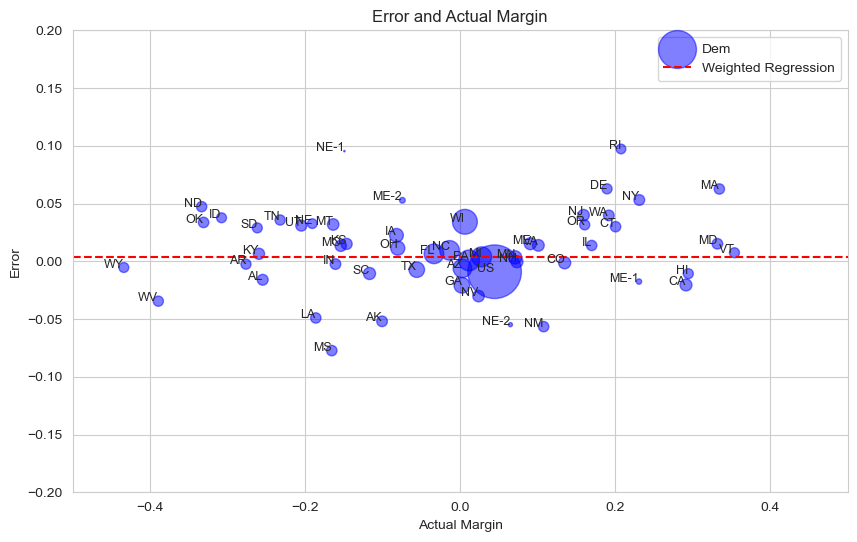

In [744]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], df_margin['error_corrected'], 
             s=df_margin['count'], color='blue', alpha=0.5, label='Dem')

# Perform weighted linear regression using 'Count' as the weight
X = df_margin['margin']
y = df_margin['error_corrected']
weights = df_margin['count']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Perform weighted least squares regression
wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

# Extract regression line parameters
slope = results.params[1]
intercept = results.params[0]

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

#ax.set_xlim(-.5, .9)
#ax.set_ylim(-.15, .15)

ax.set_xlim(-.5, .5)
ax.set_ylim(-.2, .2)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['state_code']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['error_corrected'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], df_margin['error_corrected'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Error')
plt.title('Error and Actual Margin')

# Add legend
plt.legend()

# Show plot
plt.show()

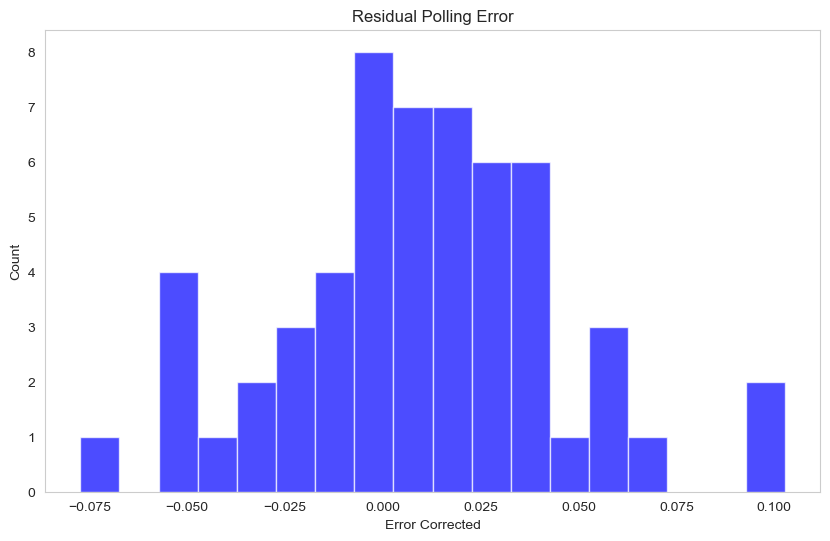

In [745]:
# Create the histogram
plt.figure(figsize=(10, 6))

bin_width = 0.01
min_edge = df_margin['error_corrected'].min()
max_edge = df_margin['error_corrected'].max()
bins = np.arange(min_edge, max_edge + bin_width, bin_width)

plt.hist(df_margin['error_corrected'], bins=bins, alpha=0.7, color='blue')

# Add labels and title
plt.xlabel('Error Corrected')
plt.ylabel('Count')
plt.title('Residual Polling Error')
plt.grid()

# Show the plot
plt.savefig('pres_2020_error_hist.png')

In [746]:
df_margin['error_corrected'].std()

0.03547669860206407